# 0. Loading the data and setting the scene 

In [1]:
!pip -q install linearmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import nan_euclidean_distances
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# 패널 회귀
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity  # scikit-learn 필요
import re
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [3]:
# archive 폴더 안의 파일 읽기
df = pd.read_csv("/Users/yujin.sophia.kim/Desktop/data/WDI/archive/WDI_Indicators_MainData.csv")

# 데이터 확인
print(df.info())
print(f"\nSize of the Data: {df.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 95 columns):
 #   Column                                                                                                                                        Non-Null Count  Dtype  
---  ------                                                                                                                                        --------------  -----  
 0   Time                                                                                                                                          209 non-null    int64  
 1   Time Code                                                                                                                                     209 non-null    object 
 2   Country Name                                                                                                                                  209 non-null    object 
 3   Country Code                       

In [4]:
df.head()

,Time,Time Code,Country Name,Country Code,"Current education expenditure, primary (% of total expenditure in primary public institutions) [SE.XPD.CPRM.ZS]","Current education expenditure, secondary (% of total expenditure in secondary public institutions) [SE.XPD.CSEC.ZS]","Current education expenditure, tertiary (% of total expenditure in tertiary public institutions) [SE.XPD.CTER.ZS]","Current education expenditure, total (% of total expenditure in public institutions) [SE.XPD.CTOT.ZS]",Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS],Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS],...,"Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]","Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.FE.ZS]","Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.MA.ZS]","Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.ZS]","Vulnerable employment, female (% of female employment) (modeled ILO estimate) [SL.EMP.VULN.FE.ZS]","Vulnerable employment, male (% of male employment) (modeled ILO estimate) [SL.EMP.VULN.MA.ZS]","Vulnerable employment, total (% of total employment) (modeled ILO estimate) [SL.EMP.VULN.ZS]","Wage and salaried workers, female (% of female employment) (modeled ILO estimate) [SL.EMP.WORK.FE.ZS]","Wage and salaried workers, male (% of male employment) (modeled ILO estimate) [SL.EMP.WORK.MA.ZS]","Wage and salaried workers, total (% of total employment) (modeled ILO estimate) [SL.EMP.WORK.ZS]"
0,2011,YR2011,Australia,AUS,NaN,NaN,NaN,NaN,8.537450,6.254561,...,5.083,10.780,11.921,11.370,7.235643,11.063700,9.325963,88.887973,82.113213,85.188598
1,2011,YR2011,Austria,AUT,98.021446,98.075523,92.646141,95.928642,10.030000,7.290000,...,4.637,9.261,9.095,9.173,9.541601,13.516962,11.665963,84.826191,79.864144,82.174537
2,2011,YR2011,Belgium,BEL,NaN,NaN,96.957092,96.381668,10.363379,7.895000,...,7.140,18.738,18.712,18.724,9.014035,12.569989,10.958520,89.264094,82.743616,85.698534
3,2011,YR2011,Canada,CAN,NaN,NaN,85.195671,89.551270,10.379509,7.289382,...,7.637,12.038,15.715,13.915,8.629436,12.284332,10.557431,88.673547,81.064832,84.659885
4,2011,YR2011,Denmark,DNK,94.645523,93.561073,98.103500,96.333221,10.410000,8.740000,...,7.769,14.381,18.144,16.306,4.440911,7.642493,6.128961,94.112424,88.018992,90.899592


In [5]:
df.describe()

,Time,"Current education expenditure, primary (% of total expenditure in primary public institutions) [SE.XPD.CPRM.ZS]","Current education expenditure, secondary (% of total expenditure in secondary public institutions) [SE.XPD.CSEC.ZS]","Current education expenditure, tertiary (% of total expenditure in tertiary public institutions) [SE.XPD.CTER.ZS]","Current education expenditure, total (% of total expenditure in public institutions) [SE.XPD.CTOT.ZS]",Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS],Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS],"Educational attainment, at least Bachelor's or equivalent, population 25+, female (%) (cumulative) [SE.TER.CUAT.BA.FE.ZS]","Educational attainment, at least Bachelor's or equivalent, population 25+, male (%) (cumulative) [SE.TER.CUAT.BA.MA.ZS]","Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative) [SE.TER.CUAT.BA.ZS]",...,"Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]","Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.FE.ZS]","Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.MA.ZS]","Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.ZS]","Vulnerable employment, female (% of female employment) (modeled ILO estimate) [SL.EMP.VULN.FE.ZS]","Vulnerable employment, male (% of male employment) (modeled ILO estimate) [SL.EMP.VULN.MA.ZS]","Vulnerable employment, total (% of total employment) (modeled ILO estimate) [SL.EMP.VULN.ZS]","Wage and salaried workers, female (% of female employment) (modeled ILO estimate) [SL.EMP.WORK.FE.ZS]","Wage and salaried workers, male (% of male employment) (modeled ILO estimate) [SL.EMP.WORK.MA.ZS]","Wage and salaried workers, total (% of total employment) (modeled ILO estimate) [SL.EMP.WORK.ZS]"
count,209.00000,160.000000,155.000000,155.000000,164.000000,209.000000,209.000000,181.000000,181.000000,182.000000,...,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,2016.00000,91.038883,92.163499,90.938089,91.710226,10.224090,7.321458,24.489600,24.446647,24.503965,...,6.619746,15.091091,16.073507,15.513435,7.869830,10.876624,9.475974,89.892182,83.842524,86.609187
std,3.16987,5.105092,4.406583,4.241498,3.991709,2.360894,1.913369,11.694871,12.018839,11.442790,...,3.920827,10.148095,9.892808,9.961708,4.172952,4.716494,4.385335,4.875040,5.910130,5.362777
min,2011.00000,69.931122,77.698563,70.385498,73.767067,3.335964,2.113965,0.262423,0.282064,0.271797,...,1.640000,3.182000,4.130000,3.668000,0.221089,0.313090,0.296355,73.044964,70.327326,71.601655
25%,2013.00000,87.947254,89.071793,88.795101,89.509956,9.380000,6.650000,18.829885,19.000000,19.868821,...,4.296000,8.757000,9.359000,8.743000,4.489211,8.057614,6.498467,87.711808,81.052217,84.298487
50%,2016.00000,91.136391,92.295937,90.971687,92.420471,10.379509,7.830000,26.912407,26.130039,27.828066,...,5.674000,11.241000,12.834000,12.147000,7.813703,10.971947,9.591485,90.099424,82.741007,86.156497
75%,2019.00000,94.732161,96.332344,93.670300,94.663853,10.970000,8.630000,32.669998,32.310001,31.912340,...,7.830000,18.546000,20.763000,19.934000,9.430590,13.516962,11.580701,93.954204,87.977852,90.076253
max,2021.00000,99.483620,99.503937,98.103500,97.966171,18.756220,10.692574,48.680000,48.639999,47.290001,...,26.094000,54.565000,56.204000,55.444000,23.795179,21.190954,22.220932,98.749044,96.776959,97.149776


# 1. Data Cleaning and Processing

- https://www.kaggle.com/code/parsabahramsari/wdi-data-cleaning-and-knn-imputation

## 1.1. Missing Data 

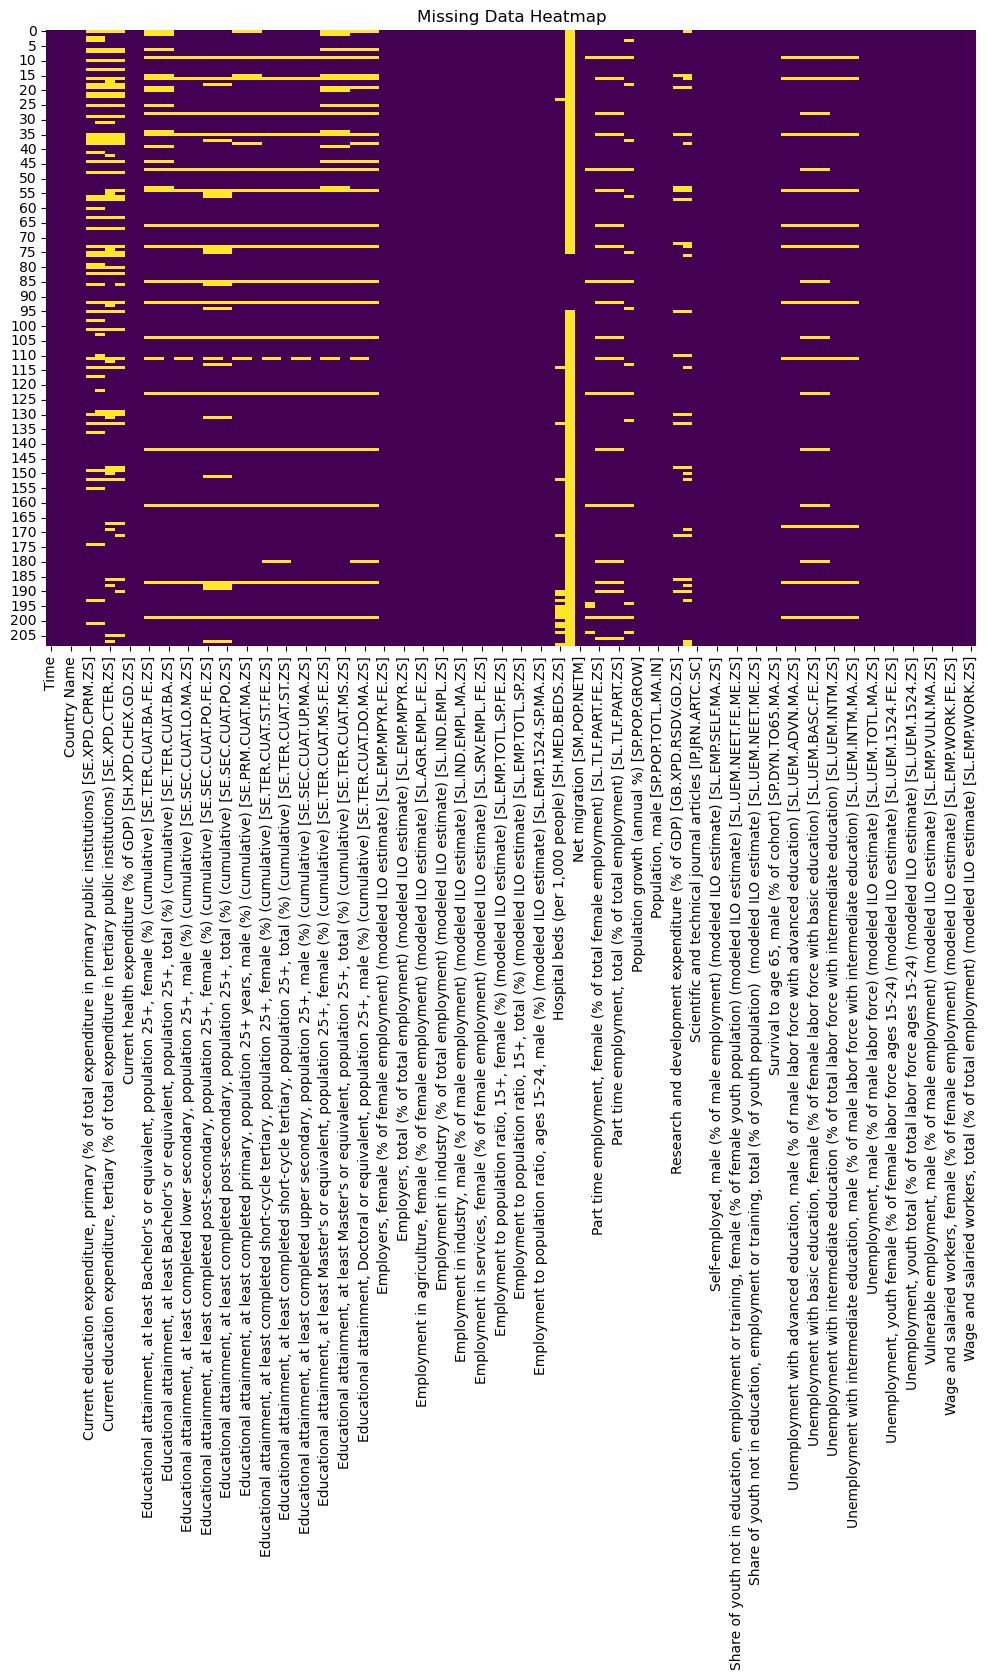

In [6]:
plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()

In [7]:
print(f'Duplicates before removal: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True)
print(f'Duplicates after removal: {df.duplicated().sum()}')

Duplicates before removal: 0
Duplicates after removal: 0


In [8]:
# Check missing percentage
missing_pct = df.isnull().mean() * 100

# Drop columns with >25% missing values
cols_to_drop = missing_pct[missing_pct > 25].index
df.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped columns: {list(cols_to_drop)}")

Dropped columns: ['Current education expenditure, secondary (% of total expenditure in secondary public institutions) [SE.XPD.CSEC.ZS]', 'Current education expenditure, tertiary (% of total expenditure in tertiary public institutions) [SE.XPD.CTER.ZS]', 'International migrant stock (% of population) [SM.POP.TOTL.ZS]']


## 1.2. Imputation

In [9]:
def comparative_country_time_imputation(df, target_col, country_col='Country Name', time_col='Time'):
    df_imputed = df.copy()
    
    # Pivot data to [Country x Year] matrix - time series analysis
    pivot_df = df_imputed.pivot(index=country_col, columns=time_col, values=target_col)
    countries = pivot_df.index
    years = pivot_df.columns

    for country in countries:
        for year in years:
            if np.isnan(pivot_df.loc[country, year]):
                # Country comparative analysis
                target_country_vector = pivot_df.loc[country].values.reshape(1, -1)
                other_countries = pivot_df.drop(country)
                country_distances = nan_euclidean_distances(target_country_vector, other_countries.values)[0]
                country_similarity_idx = np.argsort(country_distances)

                # Year comparative analysis
                target_year_vector = pivot_df[year].values.reshape(1, -1)
                other_years = pivot_df.drop(columns=year)
                year_distances = nan_euclidean_distances(target_year_vector, other_years.values.T)[0]
                year_similarity_idx = np.argsort(year_distances)

                # Select top similar countries and years clearly
                top_similar_countries = other_countries.iloc[country_similarity_idx[:5]]
                top_similar_years = other_years.iloc[:, year_similarity_idx[:5]]

                # Gather neighbor values
                country_based_values = top_similar_countries[year].dropna().values
                year_based_values = top_similar_years.loc[country].dropna().values

                # Combine these two clearly for robust imputation
                combined_values = np.concatenate([country_based_values, year_based_values])

                # Impute with average of combined values or zero if none found
                if combined_values.size > 0:
                    imputed_value = np.mean(combined_values)
                else:
                    imputed_value = 0  # Default to 0 clearly if no data available

                pivot_df.loc[country, year] = imputed_value

    # Map back to original dataframe explicitly
    for country in countries:
        for year in years:
            df_imputed.loc[
                (df_imputed[country_col] == country) & 
                (df_imputed[time_col] == year), target_col
            ] = pivot_df.loc[country, year]

    return df_imputed

In [10]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns[4:]

for col in numeric_cols:
    df = comparative_country_time_imputation(df, col)

# Verify explicitly no missing values remain
print("Remaining NaNs after advanced imputation:", df[numeric_cols].isnull().sum().sum())

Remaining NaNs after advanced imputation: 0


(209, 92)


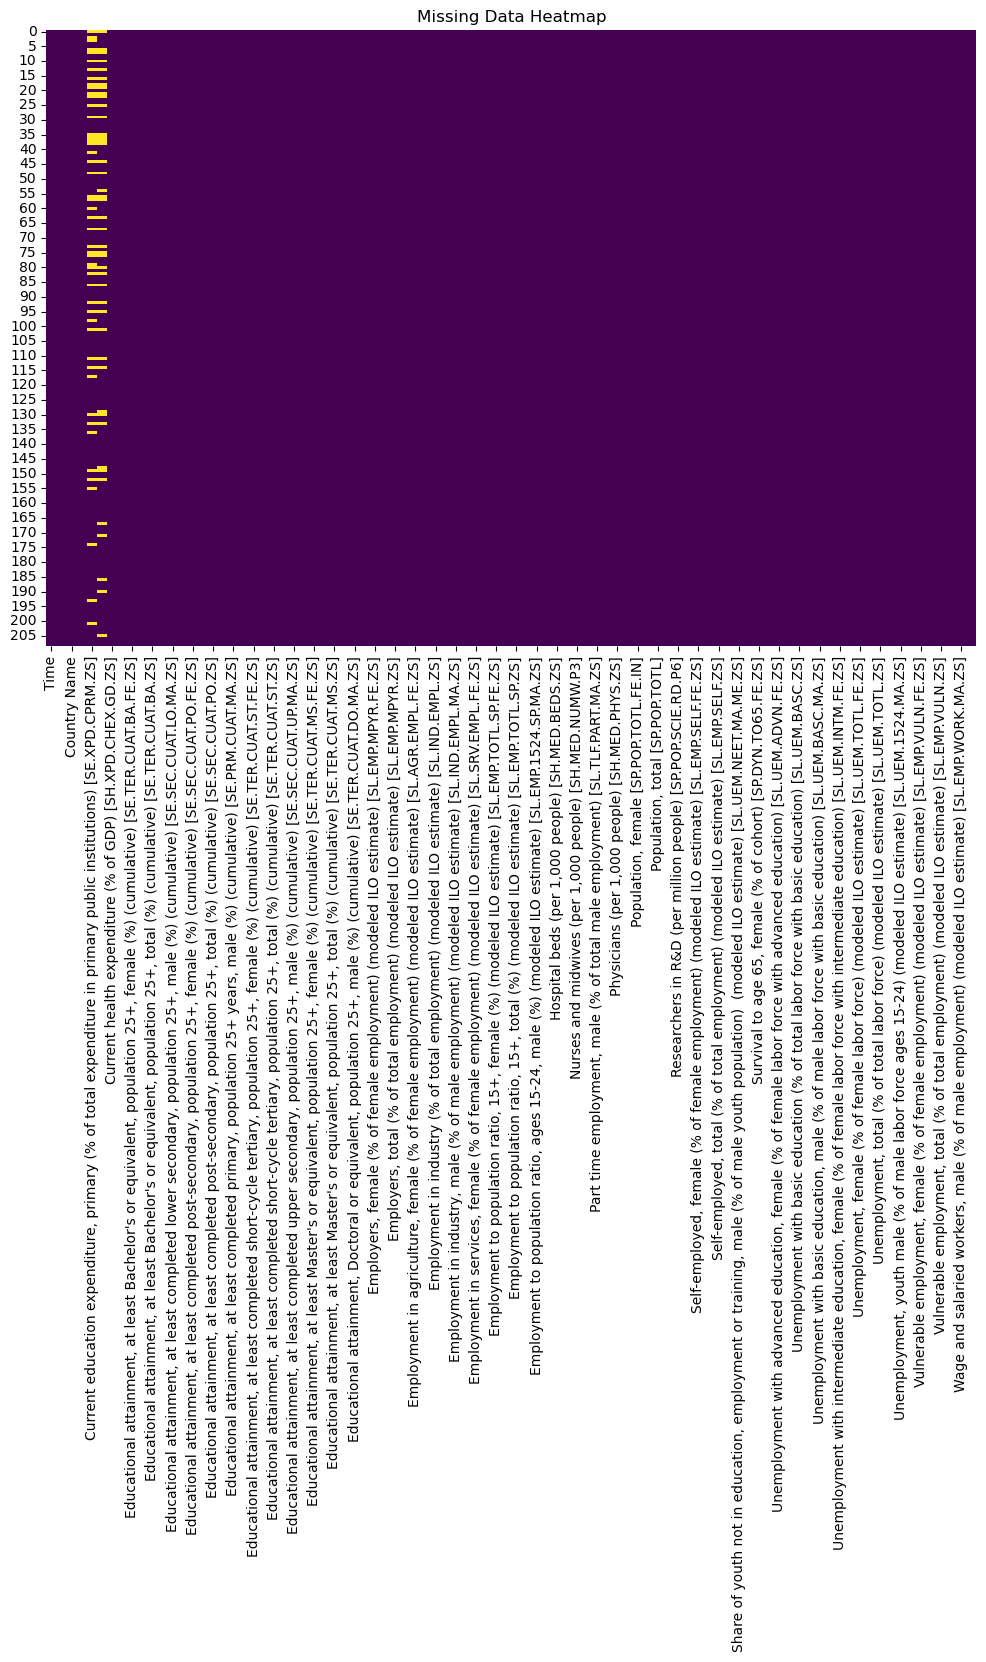

In [11]:
print(df.shape)
plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()

## 1.3. Mapping

In [12]:
# Generate country code mapping explicitly
country_mapping = {country: code for code, country in enumerate(sorted(df['Country Name'].unique()), 1)}
# 매핑 결과를 데이터프레임으로 확인
country_code_df = pd.DataFrame(country_mapping.items(), columns=['Country Name', 'Country Code']).sort_values('Country Code')
print(country_code_df.to_string(index=False))

# Replace country names with numeric codes clearly
df['Country Code'] = df['Country Name'].map(country_mapping)

# Drop original country name column explicitly
df.drop(columns=['Country Name', 'Time Code'], inplace=True)

# Reorder columns explicitly to have "Time" and "Country Code" first
cols = ['Time', 'Country Code'] + [col for col in df.columns if col not in ['Time', 'Country Code']]
df = df[cols]

        Country Name  Country Code
           Australia             1
             Austria             2
             Belgium             3
              Canada             4
             Denmark             5
             Finland             6
              France             7
             Germany             8
               Italy             9
               Japan            10
         Korea, Rep.            11
         Netherlands            12
              Norway            13
               Spain            14
              Sweden            15
         Switzerland            16
United Arab Emirates            17
      United Kingdom            18
       United States            19


In [13]:
df.head()

,Time,Country Code,"Current education expenditure, primary (% of total expenditure in primary public institutions) [SE.XPD.CPRM.ZS]","Current education expenditure, total (% of total expenditure in public institutions) [SE.XPD.CTOT.ZS]",Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS],Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS],"Educational attainment, at least Bachelor's or equivalent, population 25+, female (%) (cumulative) [SE.TER.CUAT.BA.FE.ZS]","Educational attainment, at least Bachelor's or equivalent, population 25+, male (%) (cumulative) [SE.TER.CUAT.BA.MA.ZS]","Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative) [SE.TER.CUAT.BA.ZS]","Educational attainment, at least completed lower secondary, population 25+, female (%) (cumulative) [SE.SEC.CUAT.LO.FE.ZS]",...,"Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]","Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.FE.ZS]","Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.MA.ZS]","Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.ZS]","Vulnerable employment, female (% of female employment) (modeled ILO estimate) [SL.EMP.VULN.FE.ZS]","Vulnerable employment, male (% of male employment) (modeled ILO estimate) [SL.EMP.VULN.MA.ZS]","Vulnerable employment, total (% of total employment) (modeled ILO estimate) [SL.EMP.VULN.ZS]","Wage and salaried workers, female (% of female employment) (modeled ILO estimate) [SL.EMP.WORK.FE.ZS]","Wage and salaried workers, male (% of male employment) (modeled ILO estimate) [SL.EMP.WORK.MA.ZS]","Wage and salaried workers, total (% of total employment) (modeled ILO estimate) [SL.EMP.WORK.ZS]"
0,2011,1,NaN,NaN,8.537450,6.254561,19.435627,16.702708,19.443268,93.739998,...,5.083,10.780,11.921,11.370,7.235643,11.063700,9.325963,88.887973,82.113213,85.188598
1,2011,2,98.021446,95.928642,10.030000,7.290000,6.280110,6.329326,6.705862,98.854050,...,4.637,9.261,9.095,9.173,9.541601,13.516962,11.665963,84.826191,79.864144,82.174537
2,2011,3,NaN,96.381668,10.363379,7.895000,0.306420,0.704335,0.498997,77.500000,...,7.140,18.738,18.712,18.724,9.014035,12.569989,10.958520,89.264094,82.743616,85.698534
3,2011,4,NaN,89.551270,10.379509,7.289382,24.085646,24.041842,24.064234,92.831757,...,7.637,12.038,15.715,13.915,8.629436,12.284332,10.557431,88.673547,81.064832,84.659885
4,2011,5,94.645523,96.333221,10.410000,8.740000,0.471820,0.673025,0.570325,96.480003,...,7.769,14.381,18.144,16.306,4.440911,7.642493,6.128961,94.112424,88.018992,90.899592


## 1.4. Standisation

In [14]:
# Selecting columns explicitly from the 2nd column onward (0-based indexing)
cols_to_scale = df.columns[2:]
df_normalized = df
# Initialize the StandardScaler explicitly
scaler = StandardScaler()

# Fit and transform explicitly the selected columns
df_normalized[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# Check clearly the standardized results
df_normalized.head()

,Time,Country Code,"Current education expenditure, primary (% of total expenditure in primary public institutions) [SE.XPD.CPRM.ZS]","Current education expenditure, total (% of total expenditure in public institutions) [SE.XPD.CTOT.ZS]",Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS],Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS],"Educational attainment, at least Bachelor's or equivalent, population 25+, female (%) (cumulative) [SE.TER.CUAT.BA.FE.ZS]","Educational attainment, at least Bachelor's or equivalent, population 25+, male (%) (cumulative) [SE.TER.CUAT.BA.MA.ZS]","Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative) [SE.TER.CUAT.BA.ZS]","Educational attainment, at least completed lower secondary, population 25+, female (%) (cumulative) [SE.SEC.CUAT.LO.FE.ZS]",...,"Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]","Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.FE.ZS]","Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.MA.ZS]","Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.ZS]","Vulnerable employment, female (% of female employment) (modeled ILO estimate) [SL.EMP.VULN.FE.ZS]","Vulnerable employment, male (% of male employment) (modeled ILO estimate) [SL.EMP.VULN.MA.ZS]","Vulnerable employment, total (% of total employment) (modeled ILO estimate) [SL.EMP.VULN.ZS]","Wage and salaried workers, female (% of female employment) (modeled ILO estimate) [SL.EMP.WORK.FE.ZS]","Wage and salaried workers, male (% of male employment) (modeled ILO estimate) [SL.EMP.WORK.MA.ZS]","Wage and salaried workers, total (% of total employment) (modeled ILO estimate) [SL.EMP.WORK.ZS]"
0,2011,1,NaN,NaN,-0.716123,-0.558940,-0.343154,-0.627431,-0.398426,0.500111,...,-0.392886,-0.425838,-0.420758,-0.416935,-0.152341,0.039759,-0.034290,-0.206485,-0.293304,-0.265534
1,2011,2,1.372059,1.060031,-0.082408,-0.016480,-1.458838,-1.498877,-1.527759,1.096170,...,-0.506910,-0.575880,-0.707106,-0.638009,0.401582,0.561154,0.500588,-1.041664,-0.674762,-0.828917
2,2011,3,NaN,1.173871,0.059140,0.300475,-1.965450,-1.971421,-2.078076,-1.392714,...,0.133008,0.360232,0.267349,0.323064,0.274854,0.359892,0.338881,-0.129147,-0.186383,-0.170218
3,2011,4,NaN,-0.542517,0.065989,-0.016804,0.051201,-0.010886,0.011282,0.394252,...,0.260072,-0.301576,-0.036326,-0.160843,0.182468,0.299182,0.247200,-0.250574,-0.471117,-0.364360
4,2011,5,0.708697,1.161697,0.078935,0.743165,-1.951423,-1.974051,-2.071752,0.819467,...,0.293819,-0.070141,0.209795,0.079752,-0.823674,-0.687353,-0.765061,0.867762,0.708359,0.801955


## 1.5. Save

In [15]:
df.to_csv('WDI_Final_Processed.csv', index=False)

In [16]:
data_df = pd.read_csv('./WDI_Final_Processed.csv')

/var/folders/mh/mcrn4x2d7jg9qldndqmt8nhm0000gn/T/ipykernel_17424/3214821297.py:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


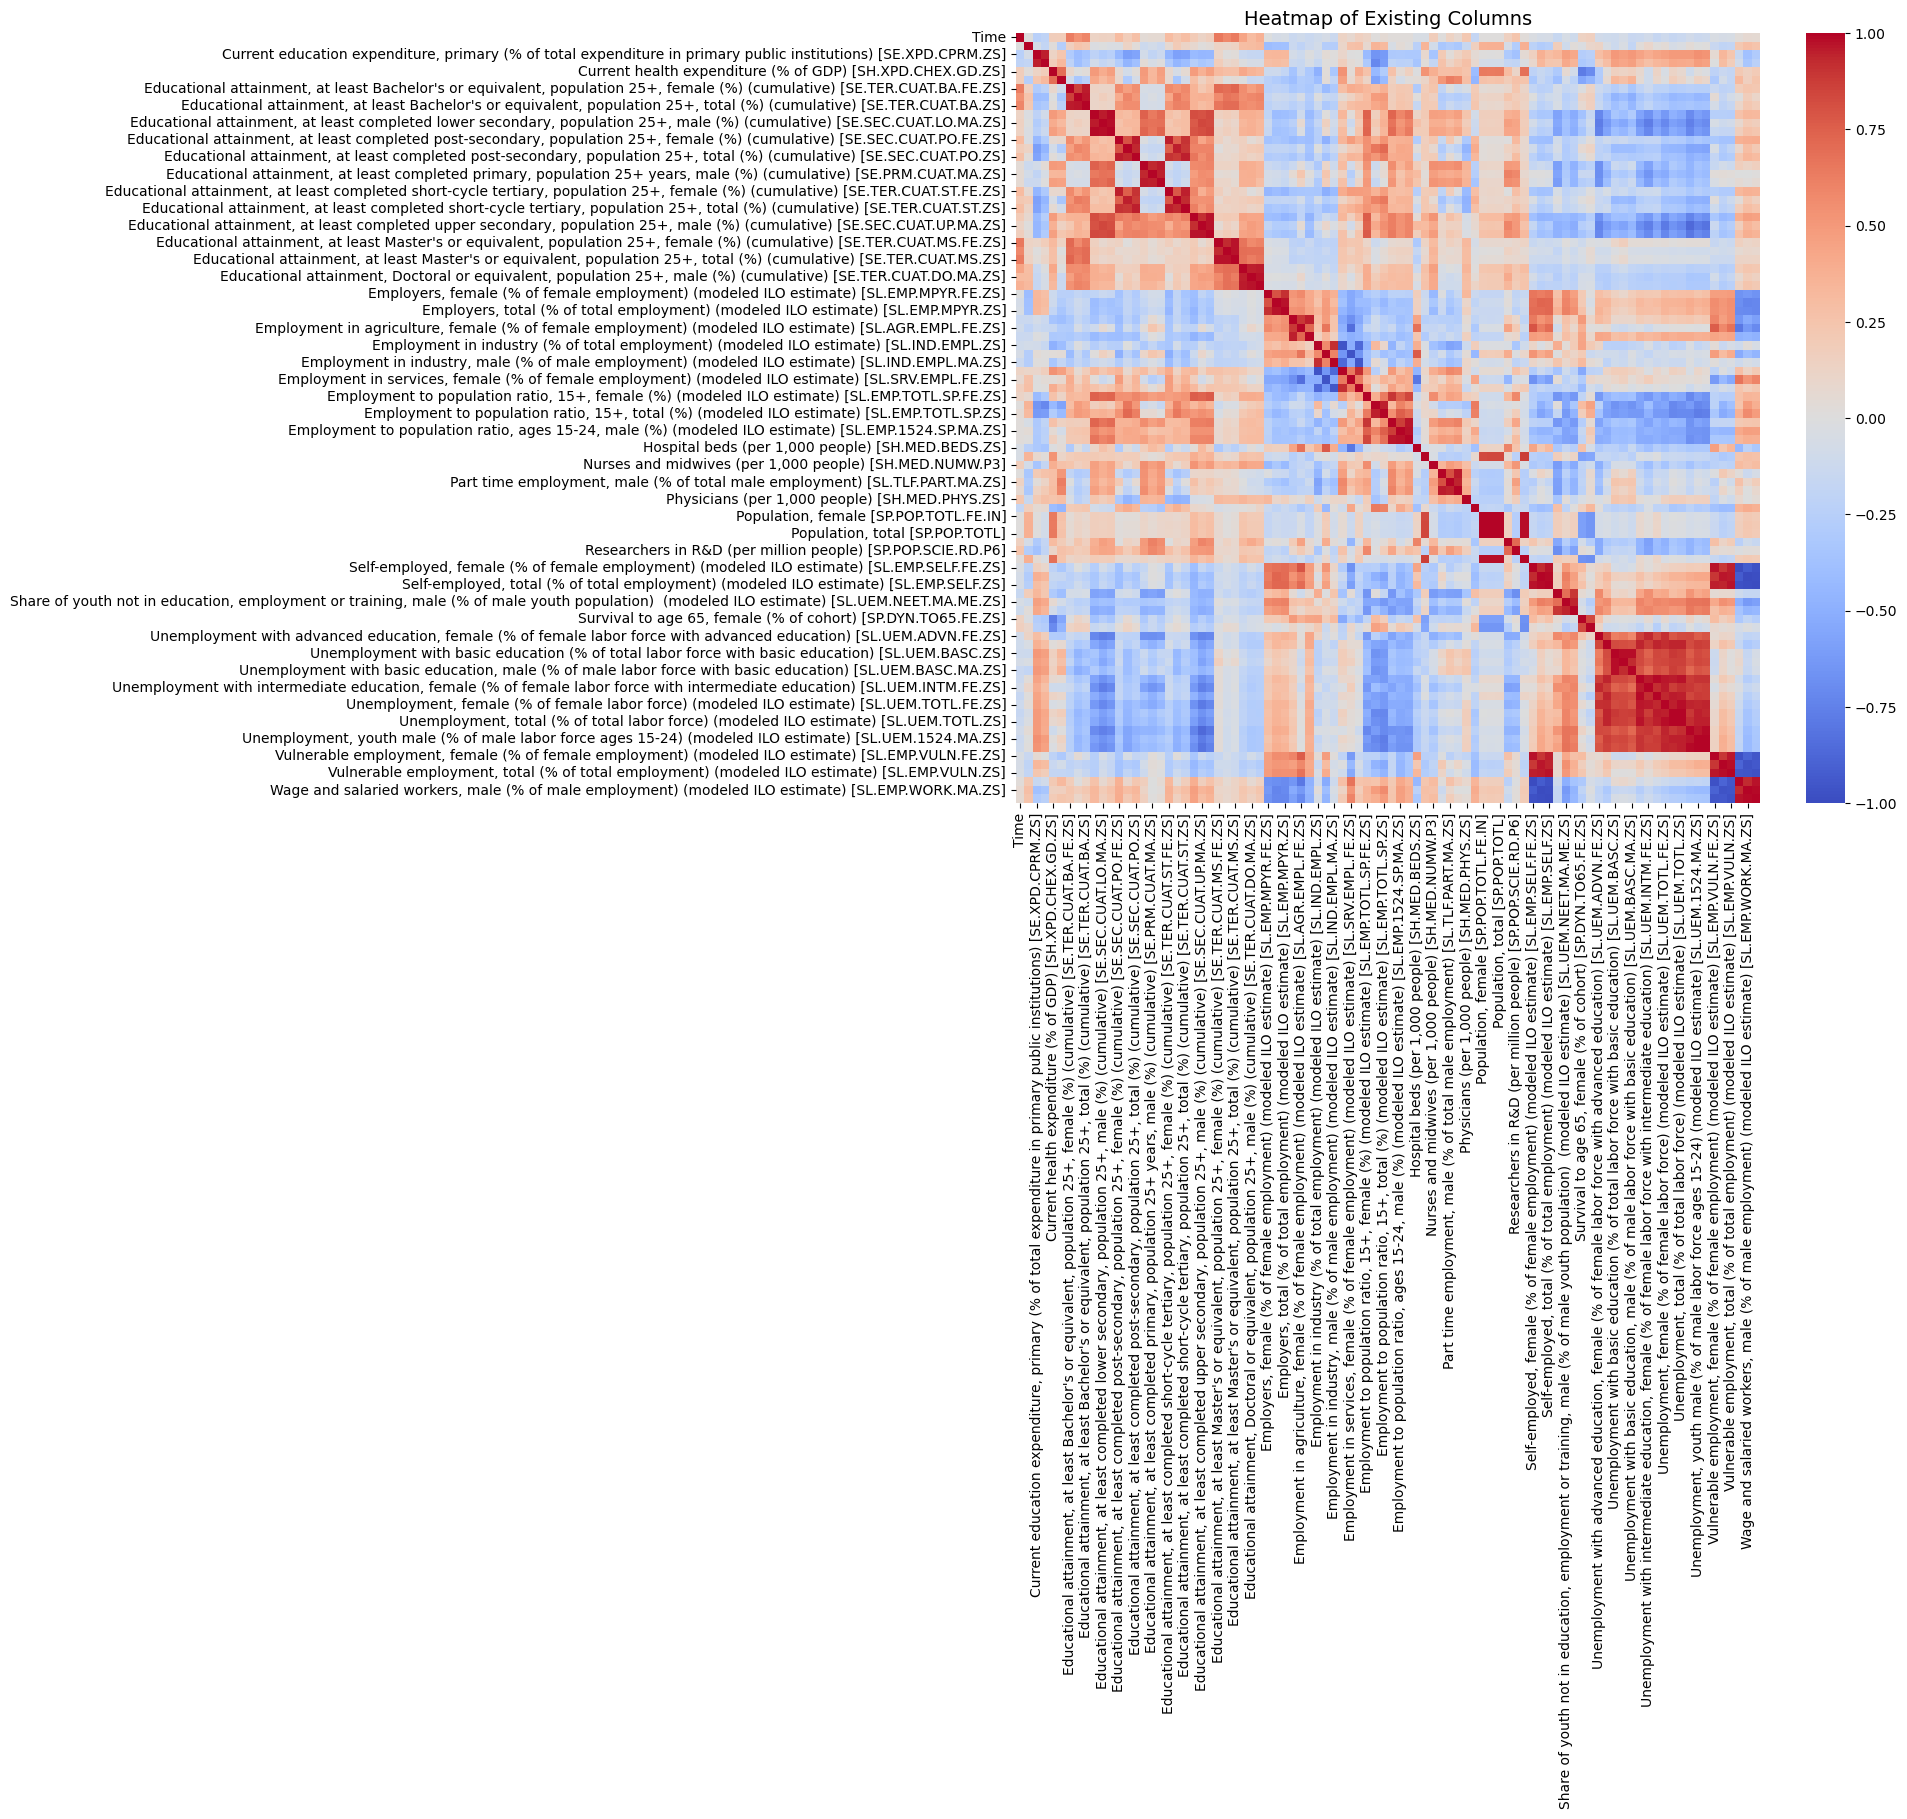

In [17]:
# existing_cols 리스트를 그대로 사용
corr = data_df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Heatmap of Existing Columns", fontsize=14)
plt.tight_layout()
plt.show()

# 2. Data Analysis

## 2.1. Data Mapping

In [18]:
# 메타데이터와 전처리된 데이터 불러오기
metadata = pd.read_excel("/Users/yujin.sophia.kim/Desktop/data/WDI/archive/WDI_Indicators_Metadata.xlsx")
data_df = pd.read_csv('./WDI_Final_Processed.csv')

In [19]:
data_df["Time"].unique()

array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [20]:
# DataFrame의 모든 컬럼 이름 출력
print(df.columns)

Index(['Time', 'Country Code',
       'Current education expenditure, primary (% of total expenditure in primary public institutions) [SE.XPD.CPRM.ZS]',
       'Current education expenditure, total (% of total expenditure in public institutions) [SE.XPD.CTOT.ZS]',
       'Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS]',
       'Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS]',
       'Educational attainment, at least Bachelor's or equivalent, population 25+, female (%) (cumulative) [SE.TER.CUAT.BA.FE.ZS]',
       'Educational attainment, at least Bachelor's or equivalent, population 25+, male (%) (cumulative) [SE.TER.CUAT.BA.MA.ZS]',
       'Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative) [SE.TER.CUAT.BA.ZS]',
       'Educational attainment, at least completed lower secondary, population 25+, female (%) (cumulative) [SE.SEC.CUAT.LO.FE.ZS]',
       'Educational attainment, at least completed lower

In [21]:
# ----------------------------------------------------------------------
# 2. indicator_alias_map 정의 (NEET Total 공백 문제 수정 완료)
# ----------------------------------------------------------------------
indicator_alias_map = {
    # 1) Data Identifiers (Country/Time)
    "Country Code": "Country Code", "Country Name": "Country Name", "Time": "Time",
    # 2) Health Expenditure
    "Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS]": "GDP_Total_HealthExp",
    "Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS]": "GDP_Gov_HealthExp",
    # 3) Unemployment
    "Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]": "JOB_Unemp_Total",
    "Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.ZS]": "JOB_Unemp_Youth_Total",
    "Vulnerable employment, total (% of total employment) (modeled ILO estimate) [SL.EMP.VULN.ZS]": "JOB_VulnerableEmployment_Total", 
    "Part time employment, total (% of total employment) [SL.TLF.PART.ZS]": "JOB_Part_Time_Total",
    "Self-employed, total (% of total employment) (modeled ILO estimate) [SL.EMP.SELF.ZS]": "JOB_Self-employed_Total",
    "Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]": "JOB_Unemployment_Total",
    "Wage and salaried workers, total (% of total employment) (modeled ILO estimate) [SL.EMP.WORK.ZS]": "JOB_Contracters_Total",
    # 6) Bachelors
    "Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative) [SE.TER.CUAT.BA.ZS]": "EDU_Bachelors_25Plus_Total",
    # 7) Primary, Secondary, Tertiary
    "Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative) [SE.SEC.CUAT.LO.ZS]": "EDU_LowerSecondary_25Plus_Total",
    "Educational attainment, at least completed post-secondary, population 25+, total (%) (cumulative) [SE.SEC.CUAT.PO.ZS]": "EDU_PostSecondary_25Plus_Total",
    "Educational attainment, at least completed primary, population 25+ years, total (%) (cumulative) [SE.PRM.CUAT.ZS]": "EDU_Primary_25Plus_Total",
    "Educational attainment, at least completed short-cycle tertiary, population 25+, total (%) (cumulative) [SE.TER.CUAT.ST.ZS]": "EDU_ShortCycleTertiary_25Plus_Total",
}


In [22]:
import re

def short_name(c):
    """긴 WDI 컬럼 이름을 Plotly 제목에 적합하게 축약합니다."""
    cl = c.lower()

    # Health
    if "current health expenditure" in cl: 
        return "HealthExp (%GDP)" 
    if "government health" in cl:         
        return "GovHealthExp (%GDP)" 

    # Employment
    if "vulnerable employment" in cl: 
        return "VulnerableEmp (%)" 
    if "unemployment, youth" in cl: 
        return "Youth Unemp (%)" 
    if "unemployment, total" in cl: 
        return "Unemp Total (%)" 
    if "part time employment" in cl: 
        return "Part-time Emp (%)"
    if "self-employed" in cl: 
        return "Self-employed (%)"
    if "wage and salaried workers" in cl or "contracters" in cl or "contractors" in cl: 
        return "Wage/Salary Workers (%)"

    # Educational Attainment
    if "bachelor" in cl: 
        return "BA+ Attainment (%)"
    if "lower secondary" in cl: 
        return "Lower Secondary+ (%)"
    if "post-secondary" in cl or "post secondary" in cl: 
        return "Post Secondary+ (%)"
    if "primary" in cl: 
        return "Primary+ (%)"
    if "short-cycle tertiary" in cl or "short cycle tertiary" in cl: 
        return "Short Tertiary+ (%)"

    # NEET
    if "neet" in cl:
        return "NEET (%)"

    # 기본 처리: 뒤의 [CODE] 제거
    return re.sub(r"\s*\[[A-Z0-9\.\-]+\]\s*$", "", c).strip()


In [23]:
# 1. 컬럼명을 alias_map 기준으로 바꾸기
data_df_update = data_df.rename(columns=indicator_alias_map)

# 2. alias_map에 정의된 컬럼만 남기기
use_cols = list(indicator_alias_map.values())
data_df_update = data_df_update[[c for c in use_cols if c in data_df_update.columns]]

## 2.2. Visualisation

In [24]:
# =============================
# Smooth Density Dashboard (KDE, Count 버튼 없음)
# - 드롭다운: 지표 교체
# - Y축: Density (부드러운 커브)
# - 셰이딩: |Z|≤1, ≤2, ≤3
# - 상단 부제: P(|Z|≤1,2,3) 및 N
# =============================

# ---- 설정 ----
YEAR_FILTER = None   # 예: 2020 (특정 연도만 보려면 숫자 지정)
exclude_cols = ["Country Name", "Country Code", "Time"]

# 표시용 별칭 함수 (indicator_alias_map가 없으면 컬럼명 그대로 사용)
def short_name(col: str) -> str:
    try:
        return indicator_alias_map.get(col, col)
    except NameError:
        return col

# --- (A) 표준화(Z-score) 분포에서 |Z|≤k의 구간 누적확률 계산 도우미 ---
def z_mass(vals, k=1.0):
    v = pd.to_numeric(vals, errors="coerce").dropna().values
    if v.size == 0:
        return np.nan
    return np.mean((v >= -k) & (v <= k))

def fmt_mass(m):
    if m is None or (isinstance(m, float) and np.isnan(m)):
        return "n/a"
    return f"{m:.1%}"

# --- (B) KDE 계산 (Silverman rule-of-thumb 대역폭) ---
def kde_xy(zvals, gridsize=512, pad=0.25):
    """표준화된 값 zvals로 KDE 곡선 (x, density) 반환"""
    v = pd.to_numeric(zvals, errors="coerce").dropna().values
    n = v.size
    if n < 2:
        # 샘플이 너무 적으면 점 두 개를 그려서 방어
        x = np.linspace(-3, 3, gridsize)
        y = np.zeros_like(x)
        return x, y
    std = np.std(v, ddof=1)
    # 표준화 데이터라도 분산이 1이 아닐 수 있어 방어적으로 추정
    bw = 1.06 * (std if std > 1e-9 else 1.0) * n ** (-1/5)

    x_min, x_max = v.min(), v.max()
    span = x_max - x_min
    # 최대한 |Z| 범위를 커버하되 데이터 범위를 중심으로 패딩
    lo = min(-3, x_min - pad * (span if span > 0 else 1))
    hi = max( 3, x_max + pad * (span if span > 0 else 1))
    x = np.linspace(lo, hi, gridsize)

    kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(v.reshape(-1,1))
    log_dens = kde.score_samples(x.reshape(-1,1))
    y = np.exp(log_dens)  # 적분이 1인 밀도
    return x, y

# ---- 1) 시각화 대상 컬럼 선정 ----
if "indicator_alias_map" in globals():
    candidates = [c for c in indicator_alias_map.keys() if c not in exclude_cols]
else:
    candidates = [c for c in data_df.columns if c not in exclude_cols]

existing = [c for c in candidates if c in data_df.columns]
if not existing:
    raise ValueError("선택 지표가 data_df에 없습니다. data_df.columns를 확인하세요.")
cols = existing

# ---- 2) 숫자 변환 & (옵션) 연도 필터 ----
df_num = data_df.copy()
for c in cols:
    df_num[c] = pd.to_numeric(df_num[c], errors="coerce")

if YEAR_FILTER is not None:
    if "Time" not in df_num.columns:
        warnings.warn("YEAR_FILTER가 지정됐지만 'Time' 컬럼이 없어 무시됩니다.")
    else:
        df_num = df_num[df_num["Time"] == YEAR_FILTER]

if df_num[cols].dropna(how="all").empty:
    raise ValueError("필터 이후 값이 없습니다. YEAR_FILTER 또는 지표 선택을 확인하세요.")

# ---- 3) 지표별 P(|Z|) 및 N 사전계산 ----
mass_info = {}
for col in cols:
    z = df_num[col].dropna()
    mass_info[col] = {
        "N": len(z),
        "p1": z_mass(z, 1.0),
        "p2": z_mass(z, 2.0),
        "p3": z_mass(z, 3.0),
    }

# ---- 4) 최초 지표 KDE ----
first_col = cols[0]
z0 = df_num[first_col].dropna()
x0, y0 = kde_xy(z0)
subtitle0 = (
    f"P(|Z|≤1)={fmt_mass(mass_info[first_col]['p1'])} · "
    f"P(|Z|≤2)={fmt_mass(mass_info[first_col]['p2'])} · "
    f"P(|Z|≤3)={fmt_mass(mass_info[first_col]['p3'])} · "
    f"N={mass_info[first_col]['N']}"
)

fig = go.Figure(
    data=[go.Scatter(
        x=x0, y=y0,
        mode="lines",
        line=dict(width=2),
        fill="tozeroy",  # 아래로 채워서 '부드러운 분포' 느낌 강화
        name="KDE",
        hovertemplate=f"<b>{short_name(first_col)}</b><br>Z: %{{x:.2f}}<br>Density: %{{y:.3f}}<extra></extra>"
    )]
)

# ---- 5) 셰이딩(그림자) 정의: |Z|≤1, ≤2, ≤3 (배경 사각형) ----
shapes_shading = [
    dict(type="rect", xref="x", yref="paper", x0=-3, x1= 3, y0=0, y1=1,
         fillcolor="rgba(0,0,0,0.06)", line=dict(width=0)),
    dict(type="rect", xref="x", yref="paper", x0=-2, x1= 2, y0=0, y1=1,
         fillcolor="rgba(0,0,0,0.10)", line=dict(width=0)),
    dict(type="rect", xref="x", yref="paper", x0=-1, x1= 1, y0=0, y1=1,
         fillcolor="rgba(0,0,0,0.16)", line=dict(width=0)),
]

# ---- 6) 드롭다운 (지표 교체 → KDE 재계산 + 부제/셰이딩 유지) ----
dropdown_buttons = []
for col in cols:
    z = df_num[col].dropna()
    xk, yk = kde_xy(z)
    info = mass_info[col]
    subtitle = (
        f"P(|Z|≤1)={fmt_mass(info['p1'])} · "
        f"P(|Z|≤2)={fmt_mass(info['p2'])} · "
        f"P(|Z|≤3)={fmt_mass(info['p3'])} · "
        f"N={info['N']}"
    )
    dropdown_buttons.append(
        dict(
            label=short_name(col),
            method="update",
            args=[
                {"x": [xk], "y": [yk]},  # KDE 곡선 교체
                {"title": f"Smooth Density — {short_name(col)}"
                          + (f" (Year {YEAR_FILTER})" if YEAR_FILTER is not None else ""),
                 "xaxis": {"title": short_name(col)},
                 "yaxis": {"title": "Density"},
                 "annotations": [{
                     "text": subtitle, "xref": "paper", "yref": "paper",
                     "x": 0.5, "y": 1.06, "showarrow": False,
                     "align": "center", "font": {"size": 12, "color": "#555"}
                 }],
                 "shapes": shapes_shading}
            ],
        )
    )

# ---- 7) 레이아웃 ----
fig.update_layout(
    height=650, width=1000,
    title=f"Smooth Density — {short_name(first_col)}" + (f" (Year {YEAR_FILTER})" if YEAR_FILTER is not None else ""),
    title_x=0.5,
    showlegend=False,
    updatemenus=[
        dict(
            type="dropdown", direction="down", x=0.0, y=1.2,
            pad={"r": 10, "t": 10}, buttons=dropdown_buttons,
            showactive=True, bgcolor="#f0f0f0", bordercolor="#ccc"
        ),
    ],
    margin=dict(l=50, r=20, t=150, b=50),
    font=dict(size=13, family="Inter, sans-serif", color="#333"),
    xaxis_title=short_name(first_col),
    yaxis_title="Density",
    xaxis=dict(gridcolor="#e5e5e5", showline=True, linewidth=1, linecolor="#ccc", type="linear"),
    yaxis=dict(gridcolor="#e5e5e5", showline=True, linewidth=1, linecolor="#ccc"),
    plot_bgcolor="#fcfcfc",
    paper_bgcolor="#ffffff",
    # 초기 부제 + 셰이딩
    annotations=[{
        "text": subtitle0, "xref":"paper","yref":"paper",
        "x":0.5,"y":1.06,"showarrow":False,"align":"center",
        "font":{"size":12,"color":"#555"}
    }],
    shapes=shapes_shading
)

fig.show()


## 2.3. Heatmaps 

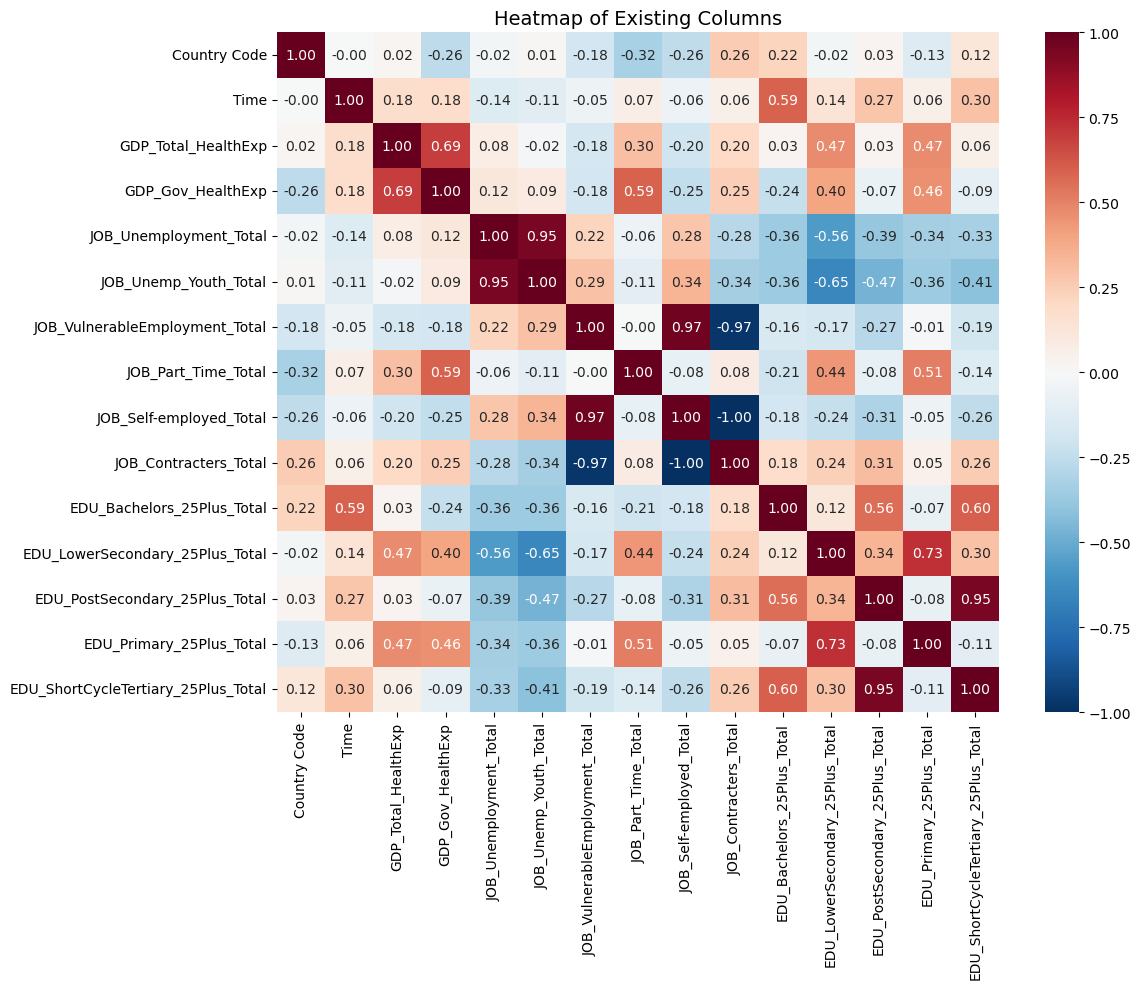

In [25]:
corr = data_df_update.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,      # 숫자 표시
    fmt=".2f",       # 소수점 둘째 자리까지
    cmap="RdBu_r",
    center=0
)

plt.title("Heatmap of Existing Columns", fontsize=14)
plt.tight_layout()
plt.show()

# 3. Economic Development and Health Expenditure

## 3.1. Data Labeling

In [26]:
# --- 데이터 로드 ---
metadata = pd.read_excel("/Users/yujin.sophia.kim/Desktop/data/WDI/archive/WDI_Indicators_Metadata.xlsx")
df = pd.read_csv("/Users/yujin.sophia.kim/Desktop/data/WDI/archive/WDI_Indicators_MainData.csv")

In [27]:
# --- 선택 & 리네임 ---
df = df[[
    "Country Name", "Time",
    "Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS]",
    "Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS]"
]].copy()

df = df.rename(columns={
    "Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS]": "GDP_Total_HealthExp",
    "Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS]": "GDP_GovHealthExp"
})

# 숫자형 변환
for col in ["GDP_Total_HealthExp", "GDP_GovHealthExp"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["Time"] = pd.to_numeric(df["Time"], errors="coerce").astype("Int64")

## 3.2. Regressions

In [28]:
# --- 라인 그래프들 ---
fig1 = px.line(
    df, x="Time", y="GDP_Total_HealthExp", color="Country Name",
    title="Total Health Expenditure (% of GDP) by Country",
    labels={"GDP_Total_HealthExp": "% of GDP", "Time": "Year"}
)
fig1.show()

fig2 = px.line(
    df, x="Time", y="GDP_GovHealthExp", color="Country Name",
    title="Government Health Expenditure (% of GDP) by Country",
    labels={"GDP_GovHealthExp": "% of GDP", "Time": "Year"}
)
fig2.show()


# --- 스캐터: Total vs Gov Health Exp (국가 평균) ---
country_avg = (
    df.groupby("Country Name")[["GDP_Total_HealthExp", "GDP_GovHealthExp"]]
      .mean(numeric_only=True)
      .dropna()
      .reset_index()
)
corr_val = country_avg["GDP_Total_HealthExp"].corr(country_avg["GDP_GovHealthExp"])
fig_scatter = px.scatter(
    country_avg,
    x="GDP_Total_HealthExp",
    y="GDP_GovHealthExp",
    text="Country Name",         # <- 인덱스 배열 대신 컬럼명 사용
    trendline="ols",             # statsmodels 미설치면 이 줄 제거
    title=f"Total vs Government Health Expenditure (% of GDP) — r = {corr_val:.2f}",
    labels={
        "GDP_Total_HealthExp": "Total Health Expenditure (% of GDP)",
        "GDP_GovHealthExp": "Government Health Expenditure (% of GDP)"
    }
)
fig_scatter.update_traces(textposition="top center")
fig_scatter.show()



## 3.3. Time Series Analysis

In [29]:
# --- 0) 안전 리네임: 코드로 원본 컬럼 찾아 매핑 ---
def _ensure_col(df, code, target):
    if target not in df.columns:
        m = [c for c in df.columns if code in c]
        if m: df = df.rename(columns={m[0]: target})
    return df

df = _ensure_col(df, "SH.XPD.CHEX.GD.ZS",  "GDP_Total_HealthExp")
df = _ensure_col(df, "SH.XPD.GHED.GD.ZS",  "GDP_GovHealthExp")

missing = [c for c in ["Country Name","Time","GDP_Total_HealthExp","GDP_GovHealthExp"] if c not in df.columns]
if missing:
    raise KeyError(f"누락 컬럼: {missing}. 원본 컬럼명을 확인하세요.")

# --- 1) 기간 필터 + 타입 정리 ---
df = df.copy()
df["Time"] = pd.to_numeric(df["Time"], errors="coerce").astype("Int64")
df = df[df["Time"].between(2011, 2021)]

# --- 2) 파생: 정부 비중(% of CHE) ---
df["GovShare_CHE_pct"] = 100 * df["GDP_GovHealthExp"] / df["GDP_Total_HealthExp"]

base = df.sort_values(["Country Name","Time"])

# --- 3) 시계열 라인 그래프 ---
fig1 = px.line(base, x="Time", y="GDP_Total_HealthExp", color="Country Name",
               markers=True, title="Total Health Expenditure (% of GDP), 2011–2021",
               labels={"GDP_Total_HealthExp":"Total Health Expenditure (% of GDP)"})
fig1.show()

fig2 = px.line(base, x="Time", y="GDP_GovHealthExp", color="Country Name",
               markers=True, title="Government Health Expenditure (% of GDP), 2011–2021",
               labels={"GDP_GovHealthExp":"Government Health Expenditure (% of GDP)"})
fig2.show()

fig3 = px.line(base, x="Time", y="GovShare_CHE_pct", color="Country Name",
               markers=True, title="Government Share of Health Expenditure (%), 2011–2021",
               labels={"GovShare_CHE_pct":"Government share of HE (%)"})
fig3.show()


# 4. Employment and Health Expenditure

## 4.1. Data Labeling

In [30]:
# --- 데이터 로드 ---
metadata = pd.read_excel("/Users/yujin.sophia.kim/Desktop/data/WDI/archive/WDI_Indicators_Metadata.xlsx")
df = pd.read_csv("/Users/yujin.sophia.kim/Desktop/data/WDI/archive/WDI_Indicators_MainData.csv")

In [31]:
# --- 선택 & 리네임 (CHE 추가, 콤마 고침) ---
df = df[[
    "Country Name", "Time",
    "Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS]",
    "Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS]",
    "Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]",
    "Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.ZS]",
    "Vulnerable employment, total (% of total employment) (modeled ILO estimate) [SL.EMP.VULN.ZS]", 
    "Part time employment, total (% of total employment) [SL.TLF.PART.ZS]",
    "Self-employed, total (% of total employment) (modeled ILO estimate) [SL.EMP.SELF.ZS]",
    "Wage and salaried workers, total (% of total employment) (modeled ILO estimate) [SL.EMP.WORK.ZS]"
]].copy()

df = df.rename(columns={
    "Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS]": "GDP_Total_HealthExp",
    "Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS]": "GDP_GovHealthExp",
    "Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]": "JOB_Unemp_Total",
    "Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.ZS]": "JOB_Unemp_Youth_Total",
    "Vulnerable employment, total (% of total employment) (modeled ILO estimate) [SL.EMP.VULN.ZS]": "JOB_VulnerableEmployment_Total", 
    "Part time employment, total (% of total employment) [SL.TLF.PART.ZS]": "JOB_Part_Time_Total",
    "Self-employed, total (% of total employment) (modeled ILO estimate) [SL.EMP.SELF.ZS]": "JOB_Self_employed_Total",
    "Wage and salaried workers, total (% of total employment) (modeled ILO estimate) [SL.EMP.WORK.ZS]": "JOB_Contracters_Total",
})

# --- 숫자형 변환 ---
for col in ["GDP_Total_HealthExp","GDP_GovHealthExp","JOB_Unemp_Total","JOB_Unemp_Youth_Total",
            "JOB_VulnerableEmployment_Total","JOB_Part_Time_Total","JOB_Self_employed_Total","JOB_Contracters_Total"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df["Time"] = pd.to_numeric(df["Time"], errors="coerce").astype("Int64")

# --- 정부보건지출의 CHE 대비 비중(%) ---
df["GovShare_CHE_pct"] = 100 * df["GDP_GovHealthExp"] / df["GDP_Total_HealthExp"]

# --- 산점도용 집계 (국가별 평균) ---
govshare_avg = (df.groupby("Country Name", as_index=False)[
    ["GDP_GovHealthExp","JOB_Unemp_Total","JOB_Unemp_Youth_Total", "JOB_Self_employed_Total",
     "JOB_VulnerableEmployment_Total","GovShare_CHE_pct"]
].mean())

## 4.2. Regression

In [32]:
# --- 1) Unemployment, Total ---

country_avg = (
    df.groupby("Country Name")[["GDP_GovHealthExp", "JOB_Unemp_Total"]]
      .mean(numeric_only=True)
      .dropna()
      .reset_index()
)
corr_val = country_avg["GDP_GovHealthExp"].corr(country_avg["JOB_Unemp_Total"])
fig_scatter = px.scatter(
    country_avg,
    x="GDP_GovHealthExp",
    y="JOB_Unemp_Total",
    text="Country Name",         # <- 인덱스 배열 대신 컬럼명 사용
    trendline="ols",             # statsmodels 미설치면 이 줄 제거
    title=f"1. Government Health Expenditure (% of GDP) VS Total Unemployment (% of total labor force) — r = {corr_val:.2f}",
    labels={
        "GDP_GovHealthExp": "Government Health Expenditure",
        "JOB_Unemp_Total": "Total Unemployment"
    }
)
fig_scatter.update_traces(textposition="top center")
fig_scatter.show()

# --- 2) Youth Unemployment ----

country_avg = (
    df.groupby("Country Name")[["GDP_GovHealthExp", "JOB_Unemp_Youth_Total"]]
      .mean(numeric_only=True)
      .dropna()
      .reset_index()
)
corr_val = country_avg["GDP_GovHealthExp"].corr(country_avg["JOB_Unemp_Youth_Total"])
fig_scatter = px.scatter(
    country_avg,
    x="GDP_GovHealthExp",
    y="JOB_Unemp_Youth_Total",
    text="Country Name",         # <- 인덱스 배열 대신 컬럼명 사용
    trendline="ols",             # statsmodels 미설치면 이 줄 제거
    title=f"2. Government Health Expenditure (% of GDP) VS Youth Unemployment (% of total labor force) — r = {corr_val:.2f}",
    labels={
        "GDP_GovHealthExp": "Government Health Expenditure",
        "JOB_Unemp_Youth_Total": "Youth Unemployment (Ages 15-24)"
    }
)
fig_scatter.update_traces(textposition="top center")
fig_scatter.show()

# --- 3) VulnerableEmployment ---

country_avg = (
    df.groupby("Country Name")[["GDP_GovHealthExp", "JOB_VulnerableEmployment_Total"]]
      .mean(numeric_only=True)
      .dropna()
      .reset_index()
)
corr_val = country_avg["GDP_GovHealthExp"].corr(country_avg["JOB_VulnerableEmployment_Total"])
fig_scatter = px.scatter(
    country_avg,
    x="GDP_GovHealthExp",
    y="JOB_VulnerableEmployment_Total",
    text="Country Name",         # <- 인덱스 배열 대신 컬럼명 사용
    trendline="ols",             # statsmodels 미설치면 이 줄 제거
    title=f"3. Government Health Expenditure (% of GDP) VS Vulnerable Employment (% of total employment) — r = {corr_val:.2f}",
    labels={
        "GDP_GovHealthExp": "Government Health Expenditure",
        "JOB_VulnerableEmployment_Total": "Vulnerable employees"
    }
)
fig_scatter.update_traces(textposition="top center")
fig_scatter.show()

# --- 4) Part_Time_Total ---

country_avg = (
    df.groupby("Country Name")[["GDP_GovHealthExp", "JOB_Part_Time_Total"]]
      .mean(numeric_only=True)
      .dropna()
      .reset_index()
)
corr_val = country_avg["GDP_GovHealthExp"].corr(country_avg["JOB_Part_Time_Total"])
fig_scatter = px.scatter(
    country_avg,
    x="GDP_GovHealthExp",
    y="JOB_Part_Time_Total",
    text="Country Name",         # <- 인덱스 배열 대신 컬럼명 사용
    trendline="ols",             # statsmodels 미설치면 이 줄 제거
    title=f"4. Government Health Expenditure (% of GDP) VS Part Time Employment (% of total employment) — r = {corr_val:.2f}",
    labels={
        "GDP_GovHealthExp": "Government Health Expenditure",
        "JOB_Part_Time_Total": "Part time employmees"
    }
)
fig_scatter.update_traces(textposition="top center")
fig_scatter.show()

# --- 5) JOB_Self_employed_Total ---

country_avg = (
    df.groupby("Country Name")[["GDP_GovHealthExp", "JOB_Self_employed_Total"]]
      .mean(numeric_only=True)
      .dropna()
      .reset_index()
)
corr_val = country_avg["GDP_GovHealthExp"].corr(country_avg["JOB_Self_employed_Total"])
fig_scatter = px.scatter(
    country_avg,
    x="GDP_GovHealthExp",
    y="JOB_Self_employed_Total",
    text="Country Name",         # <- 인덱스 배열 대신 컬럼명 사용
    trendline="ols",             # statsmodels 미설치면 이 줄 제거
    title=f"5. Government Health Expenditure (% of GDP) VS Self_Employed (% of total employment) — r = {corr_val:.2f}",
    labels={
        "GDP_GovHealthExp": "Government Health Expenditure",
        "JOB_Self_employed_Total": "Self_employed"
    }
)
fig_scatter.update_traces(textposition="top center")
fig_scatter.show()

# --- 6) JOB_Contracters_Total ---

country_avg = (
    df.groupby("Country Name")[["GDP_GovHealthExp", "JOB_Contracters_Total"]]
      .mean(numeric_only=True)
      .dropna()
      .reset_index()
)
corr_val = country_avg["GDP_GovHealthExp"].corr(country_avg["JOB_Contracters_Total"])
fig_scatter = px.scatter(
    country_avg,
    x="GDP_GovHealthExp",
    y="JOB_Contracters_Total",
    text="Country Name",         # <- 인덱스 배열 대신 컬럼명 사용
    trendline="ols",             # statsmodels 미설치면 이 줄 제거
    title=f"6. Government Health Expenditure (% of GDP) VS Wage and Salaried Workers (% of total employment) — r = {corr_val:.2f}",
    labels={
        "GDP_GovHealthExp": "Government Health Expenditure",
        "JOB_Contracters_Total": "Wage and salaried employees"
    }
)
fig_scatter.update_traces(textposition="top center")
fig_scatter.show()


## 4.3. Time Series Analysis

In [33]:
# 1) 기간 필터
df_ts = df[df["Time"].between(2011, 2021)].copy()

# 2) 시계열 라인 (변수별로 간단 반복)
plots = [
    ("JOB_Part_Time_Total",         "Part-time Employment (%)",              "Part-time Employment (%)"),
    ("JOB_VulnerableEmployment_Total","Vulnerable Employment (%)",           "Vulnerable Employment (%)"),
    ("JOB_Unemp_Total",             "Unemployment Rate (%)",                 "Unemployment (%)"),
    ("JOB_Unemp_Youth_Total",       "Youth Unemployment Rate (%)",           "Youth Unemployment (%)"),
    ("JOB_Self_employed_Total",     "Self_employeed Rate (%)",               "Self_Employeed (%)")
]

for col, title, ylab in plots:
    if col in df_ts.columns:
        fig = px.line(
            df_ts.sort_values(["Country Name","Time"]),
            x="Time", y=col, color="Country Name", markers=True,
            title=f"{title}, 2011–2021",
            labels={col: ylab}
        )
        fig.show()

In [34]:
# 누적(≥) 지표 약칭
Unemp   = "JOB_Unemp_Total"         
Unemp_Youth  = "JOB_Unemp_Youth_Total" 
Vulnerable  = "JOB_VulnerableEmployment_Total" 
Part = "JOB_Part_Time_Total"     
Self_employed  = "JOB_Self_employed_Total"      
Contracters = "JOB_Contracters_Total"

# 1) Contracters
df["JOB_Contracters_Total"] = df[Contracters]

# 2) Self_employeed
df["JOB_Self_employed_Total"] = df[Self_employed]

# 3) Part_time
df["JOB_Part_Time_Total"] = df[Part] 

# 4) Vulnerable
df["JOB_VulnerableEmployment_Total"] = df[Vulnerable]

# 5) Youth Unemployment
df["JOB_Unemp_Youth_Total"] = df[Unemp_Youth]

# 6) Unemployment
df["JOB_Unemp_Total"] = df[Unemp]

In [35]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ---- 설정 ----
YR0, YR1 = 2011, 2021
UNEMP = "JOB_Unemp_Total"                  # % of labor force
PART  = "JOB_Part_Time_Total"              # % of employment
VULN  = "JOB_VulnerableEmployment_Total"   # % of employment
SELF  = "JOB_Self_employed_Total"          # % of employment
WAGE  = "JOB_Contracters_Total"            # % of employment (임금근로)

need = [UNEMP, PART, VULN, SELF, WAGE]
present = [c for c in need if c in df.columns]
assert UNEMP in present, "실업률(JOB_Unemp_Total)이 필요합니다."

# ---- 기간 필터 & 타입 보정 ----
df_ts = df[df["Time"].between(YR0, YR1)].copy()
df_ts["Time"] = pd.to_numeric(df_ts["Time"], errors="coerce")
for c in present:
    df_ts[c] = pd.to_numeric(df_ts[c], errors="coerce").clip(0, 100)

# ---- Employment rate (= 100 - Unemployment) [of labor force] ----
df_ts["EMP_Rate_LF"] = (100 - df_ts[UNEMP]).clip(0, 100)

# ---- 연도별 글로벌 평균(국가 단순 평균) ----
use_means = ["EMP_Rate_LF", UNEMP] + [c for c in [PART, VULN, SELF, WAGE] if c in df_ts.columns]
yearly = df_ts.groupby("Time")[use_means].mean().reset_index()

# =========================
# A) 2011=100 지수화 (상대변화)
# =========================
pretty = {
    "EMP_Rate_LF": "Employment rate (LF)",
    UNEMP:         "Unemployment (LF)",
    PART:          "Part-time (of employment)",
    VULN:          "Vulnerable (of employment)",
    SELF:          "Self-employed (of employment)",
    WAGE:          "Wage & salaried (of employment)",
}

tmp = yearly.rename(columns={k:v for k,v in pretty.items() if k in yearly.columns})
long = tmp.melt(id_vars="Time", var_name="Indicator", value_name="Value").dropna()

base = (long[long["Time"] == YR0]
        .drop_duplicates("Indicator")[["Indicator","Value"]]
        .rename(columns={"Value":"Base"}))
long = long.merge(base, on="Indicator", how="left")
long["Index2011"] = 100 * long["Value"] / long["Base"]

fig_idx = px.line(
    long.sort_values(["Indicator","Time"]),
    x="Time", y="Index2011", color="Indicator", markers=True,
    title="Global Means — Employment & Composition (Indexed to 2011=100)",
    labels={"Index2011":"Index (2011=100)", "Indicator":""}
)
fig_idx.update_layout(legend=dict(orientation="v", x=1.02, xanchor="left", y=1, yanchor="top"),
                      margin=dict(r=200))
fig_idx.show()

# 5. Education and health Employemnt

### 5.1. Data Labeling

In [36]:
# --- 데이터 로드 ---
metadata = pd.read_excel("/Users/yujin.sophia.kim/Desktop/data/WDI/archive/WDI_Indicators_Metadata.xlsx")
df = pd.read_csv("/Users/yujin.sophia.kim/Desktop/data/WDI/archive/WDI_Indicators_MainData.csv")

In [37]:
# --- 선택 & 리네임 (CHE 추가, 콤마 고침) ---
df = df[[
    "Country Name", "Time",
    "Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS]",
    "Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS]",
    "Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative) [SE.TER.CUAT.BA.ZS]",
    "Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative) [SE.SEC.CUAT.LO.ZS]",
    "Educational attainment, at least completed post-secondary, population 25+, total (%) (cumulative) [SE.SEC.CUAT.PO.ZS]",
    "Educational attainment, at least completed primary, population 25+ years, total (%) (cumulative) [SE.PRM.CUAT.ZS]",
    "Educational attainment, at least completed short-cycle tertiary, population 25+, total (%) (cumulative) [SE.TER.CUAT.ST.ZS]"
]].copy()

df = df.rename(columns={
    "Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS]": "GDP_Total_HealthExp",
    "Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS]": "GDP_GovHealthExp",
    "Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative) [SE.TER.CUAT.BA.ZS]": "EDU_Bachelors_25Plus_Total",
    "Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative) [SE.SEC.CUAT.LO.ZS]": "EDU_LowerSecondary_25Plus_Total",
    "Educational attainment, at least completed post-secondary, population 25+, total (%) (cumulative) [SE.SEC.CUAT.PO.ZS]": "EDU_PostSecondary_25Plus_Total",
    "Educational attainment, at least completed primary, population 25+ years, total (%) (cumulative) [SE.PRM.CUAT.ZS]": "EDU_Primary_25Plus_Total",
    "Educational attainment, at least completed short-cycle tertiary, population 25+, total (%) (cumulative) [SE.TER.CUAT.ST.ZS]": "EDU_ShortCycleTertiary_25Plus_Total"
})

# --- 숫자형 변환 ---
for col in ["GDP_Total_HealthExp","GDP_GovHealthExp",
            "EDU_Bachelors_25Plus_Total","EDU_LowerSecondary_25Plus_Total",
            "EDU_PostSecondary_25Plus_Total","EDU_Primary_25Plus_Total",
            "EDU_ShortCycleTertiary_25Plus_Total"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df["Time"] = pd.to_numeric(df["Time"], errors="coerce").astype("Int64")

# --- 정부보건지출의 CHE 대비 비중(%) ---
df["GovShare_CHE_pct"] = 100 * df["GDP_GovHealthExp"] / df["GDP_Total_HealthExp"]

# --- 산점도용 집계 (국가별 평균) ---
govshare_avg = df.groupby("Country Name", as_index=False)[[
    "GDP_Total_HealthExp","GDP_GovHealthExp",
    "EDU_Bachelors_25Plus_Total","EDU_LowerSecondary_25Plus_Total",
    "EDU_PostSecondary_25Plus_Total","EDU_Primary_25Plus_Total",
    "EDU_ShortCycleTertiary_25Plus_Total","GovShare_CHE_pct"
]].mean()

### 5.2. Regressions

In [38]:
# --- 1) EDU_Bachelors_25Plus_Total ---

country_avg = (
    df.groupby("Country Name")[["GDP_GovHealthExp", "EDU_Bachelors_25Plus_Total"]]
      .mean(numeric_only=True)
      .dropna()
      .reset_index()
)
corr_val = country_avg["GDP_GovHealthExp"].corr(country_avg["EDU_Bachelors_25Plus_Total"])
fig_scatter = px.scatter(
    country_avg,
    x="GDP_GovHealthExp",
    y="EDU_Bachelors_25Plus_Total",
    text="Country Name",         # <- 인덱스 배열 대신 컬럼명 사용
    trendline="ols",             # statsmodels 미설치면 이 줄 제거
    title=f"1. Government Health Expenditure VS At least Bachelor's or equivalent, Age over 25 (%) — r = {corr_val:.2f}",
    labels={
        "GDP_GovHealthExp": "Government Health Expenditure (% of GDP)",
        "EDU_Bachelors_25Plus_Total": "Bachelor's or equivalent (%)"
    }
)
fig_scatter.update_traces(textposition="top center")
fig_scatter.show()

# --- 2) EDU_LowerSecondary_25Plus_Total ----

country_avg = (
    df.groupby("Country Name")[["GDP_GovHealthExp", "EDU_LowerSecondary_25Plus_Total"]]
      .mean(numeric_only=True)
      .dropna()
      .reset_index()
)
corr_val = country_avg["GDP_GovHealthExp"].corr(country_avg["EDU_LowerSecondary_25Plus_Total"])
fig_scatter = px.scatter(
    country_avg,
    x="GDP_GovHealthExp",
    y="EDU_LowerSecondary_25Plus_Total",
    text="Country Name",         # <- 인덱스 배열 대신 컬럼명 사용
    trendline="ols",             # statsmodels 미설치면 이 줄 제거
    title=f"2. Government Health Expenditure VS At least completed lower secondary, Age over 25 (%) — r = {corr_val:.2f}",
    labels={
        "GDP_GovHealthExp": "Government Health Expenditure (% of GDP)",
        "EDU_LowerSecondary_25Plus_Total": "Lower secondary (%)"
    }
)
fig_scatter.update_traces(textposition="top center")
fig_scatter.show()

# --- 3) EDU_PostSecondary_25Plus_Total ---

country_avg = (
    df.groupby("Country Name")[["GDP_GovHealthExp", "EDU_PostSecondary_25Plus_Total"]]
      .mean(numeric_only=True)
      .dropna()
      .reset_index()
)
corr_val = country_avg["GDP_GovHealthExp"].corr(country_avg["EDU_PostSecondary_25Plus_Total"])
fig_scatter = px.scatter(
    country_avg,
    x="GDP_GovHealthExp",
    y="EDU_PostSecondary_25Plus_Total",
    text="Country Name",         # <- 인덱스 배열 대신 컬럼명 사용
    trendline="ols",             # statsmodels 미설치면 이 줄 제거
    title=f"3. Government Health Expenditure VS At least completed post-secondary, Age over 25 (%) — r = {corr_val:.2f}",
    labels={
        "GDP_GovHealthExp": "Government Health Expenditure (% of GDP)",
        "EDU_PostSecondary_25Plus_Total": "Post-secondary (%)"
    }
)
fig_scatter.update_traces(textposition="top center")
fig_scatter.show()

# --- 4) EDU_Primary_25Plus_Total ---

country_avg = (
    df.groupby("Country Name")[["GDP_GovHealthExp", "EDU_Primary_25Plus_Total"]]
      .mean(numeric_only=True)
      .dropna()
      .reset_index()
)
corr_val = country_avg["GDP_GovHealthExp"].corr(country_avg["EDU_Primary_25Plus_Total"])
fig_scatter = px.scatter(
    country_avg,
    x="GDP_GovHealthExp",
    y="EDU_Primary_25Plus_Total",
    text="Country Name",         # <- 인덱스 배열 대신 컬럼명 사용
    trendline="ols",             # statsmodels 미설치면 이 줄 제거
    title=f"4. Government Health Expenditure VS At least completed primary, Age over 25 (%) — r = {corr_val:.2f}",
    labels={
        "GDP_GovHealthExp": "Government Health Expenditure (% of GDP)",
        "EDU_Primary_25Plus_Total": "Primary (%)"
    }
)
fig_scatter.update_traces(textposition="top center")
fig_scatter.show()

# --- 5) EDU_ShortCycleTertiary_25Plus_Total ---

country_avg = (
    df.groupby("Country Name")[["GDP_GovHealthExp", "EDU_ShortCycleTertiary_25Plus_Total"]]
      .mean(numeric_only=True)
      .dropna()
      .reset_index()
)
corr_val = country_avg["GDP_GovHealthExp"].corr(country_avg["EDU_ShortCycleTertiary_25Plus_Total"])
fig_scatter = px.scatter(
    country_avg,
    x="GDP_GovHealthExp",
    y="EDU_ShortCycleTertiary_25Plus_Total",
    text="Country Name",         # <- 인덱스 배열 대신 컬럼명 사용
    trendline="ols",             # statsmodels 미설치면 이 줄 제거
    title=f"5. Government Health Expenditure VS At least completed short-cycle tertiary, Age over 25 (%) — r = {corr_val:.2f}",
    labels={
        "GDP_GovHealthExp": "Government Health Expenditure (% of GDP)",
        "EDU_ShortCycleTertiary_25Plus_Total": "Short-cycle tertiary (%)"
    }
)
fig_scatter.update_traces(textposition="top center")
fig_scatter.show()

### 5.2. Time Series Analysis

In [39]:
import numpy as np

# 누적(≥) 지표 약칭
BAp   = "EDU_Bachelors_25Plus_Total"         # ISCED 6+
SCtp  = "EDU_ShortCycleTertiary_25Plus_Total" # ISCED 5+
PSnp  = "EDU_PostSecondary_25Plus_Total"      # ISCED 4+
LSp   = "EDU_LowerSecondary_25Plus_Total"     # ISCED 2+
PRMp  = "EDU_Primary_25Plus_Total"            # ISCED 1+

# 1) BA+ (배타): 그대로 BA 이상
df["EXC_BAplus"] = df[BAp]

# 2) Short-cycle만 (ISCED 5만): ≥5 에서 ≥6을 뺌
df["EXC_ShortCycle_only"] = df[SCtp] - df[BAp]

# 3) Post-secondary 비(非)대학만 (ISCED 4만): ≥4 에서 ≥5를 뺌
df["EXC_PostSecondary_only"] = df[PSnp] - df[SCtp]

# 4) Lower+Upper secondary 묶음(ISCED 2~3): ≥2 에서 ≥4를 뺌
#   *Upper secondary(≥3) 지표가 없어서 2와 3을 분리하긴 어려움
df["EXC_Lower_or_UpperSec"] = df[LSp] - df[PSnp]

# 5) Primary only or below-secondary(ISCED 1만): ≥1 에서 ≥2를 뺌
df["EXC_Primary_only"] = df[PRMp] - df[LSp]

# 6) Below primary(ISCED 0 이하)
df["EXC_BelowPrimary"] = 100 - df[PRMp]


In [40]:
YR0, YR1 = 2011, 2021
df_ts = df[df["Time"].between(YR0, YR1)].copy()

# 사용할 지표 (존재하는 것만 자동 사용)
edu_labels = {
    "EDU_Bachelors_25Plus_Total":        "BA+ (25+, %)",
    "EDU_LowerSecondary_25Plus_Total":   "Lower Secondary+ (25+, %)",
    "EDU_PostSecondary_25Plus_Total":    "Post-secondary+ (25+, %)",
    "EDU_Primary_25Plus_Total":          "Primary+ (25+, %)",
    "EDU_ShortCycleTertiary_25Plus_Total":"Short-cycle Tertiary (25+, %)",
}
cols = [c for c in edu_labels if c in df_ts.columns]
assert len(cols) > 0, "교육 지표 컬럼이 없습니다."

# ----------------------------
# 1) 연도별 글로벌 평균/중앙값
# ----------------------------
yearly = (df_ts
          .groupby("Time")[cols]
          .agg(["mean","median","count"])
          .reset_index())

# 컬럼 평탄화: <지표>_<통계>
yearly.columns = ["Time"] + [f"{a}_{b}" for a,b in yearly.columns.tolist()[1:]]

# ==== Mean만 한 그래프에 ====
# (1) mean 컬럼 → 보기 좋은 라벨로 변환해서 long 형태로
mean_map = {f"{c}_mean": edu_labels[c] for c in cols if f"{c}_mean" in yearly.columns}
df_mean = yearly[["Time"] + list(mean_map.keys())].rename(columns=mean_map)
long_mean = df_mean.melt(id_vars="Time", var_name="Indicator", value_name="Mean")

# (2) 한 그래프에 모든 지표 mean 라인
fig = px.line(
    long_mean, x="Time", y="Mean", color="Indicator", markers=True,
    title=f"Global Means by Indicator (2011–2021)",
    labels={"Mean": "% of 25+ population", "Indicator": ""}
)
fig.update_layout(
    legend=dict(
        orientation="v",  # 세로
        xanchor="left",   # 오른쪽 바깥에 둘 거라 left로 고정
        x=1.02,           # 플롯의 오른쪽 밖
        yanchor="top",
        y=1
    ),
    margin=dict(r=180)    # 오른쪽 여백 늘리기 (필요에 따라 조절)
)

fig.update_yaxes(range=[0, 100])  # 퍼센트이면 유지, 아니면 지워도 OK
fig.show()

In [41]:
import numpy as np

# 누적(≥) 지표 약칭
BAp   = "EDU_Bachelors_25Plus_Total"         # ISCED 6+
SCtp  = "EDU_ShortCycleTertiary_25Plus_Total" # ISCED 5+
PSnp  = "EDU_PostSecondary_25Plus_Total"      # ISCED 4+
LSp   = "EDU_LowerSecondary_25Plus_Total"     # ISCED 2+
PRMp  = "EDU_Primary_25Plus_Total"            # ISCED 1+

# 1) BA+ (배타): 그대로 BA 이상
df["EXC_BAplus"] = df[BAp]

# 2) Short-cycle만 (ISCED 5만): ≥5 에서 ≥6을 뺌
df["EXC_ShortCycle_only"] = df[SCtp] - df[BAp]

# 3) Post-secondary 비(非)대학만 (ISCED 4만): ≥4 에서 ≥5를 뺌
df["EXC_PostSecondary_only"] = df[PSnp] - df[SCtp]

# 4) Lower+Upper secondary 묶음(ISCED 2~3): ≥2 에서 ≥4를 뺌
#   *Upper secondary(≥3) 지표가 없어서 2와 3을 분리하긴 어려움
df["EXC_Lower_or_UpperSec"] = df[LSp] - df[PSnp]

# 5) Primary only or below-secondary(ISCED 1만): ≥1 에서 ≥2를 뺌
df["EXC_Primary_only"] = df[PRMp] - df[LSp]

# 6) Below primary(ISCED 0 이하)
df["EXC_BelowPrimary"] = 100 - df[PRMp]


In [42]:
import numpy as np
import pandas as pd
import plotly.express as px

# ===== 0) 설정 =====
YR0, YR1 = 2011, 2021
# COUNTRY = None  # 전세계 평균 (Global mean)
COUNTRY = None     # 한 나라를 보고 싶으면 예: "Korea, Rep."

# 배타 카테고리(있는 것만 자동 사용)
exc_cols_all = [
    "EXC_BAplus",
    "EXC_ShortCycle_only",
    "EXC_PostSecondary_only",
    "EXC_Lower_or_UpperSec",
    "EXC_Primary_only",
    "EXC_BelowPrimary",
]
exc_cols = [c for c in exc_cols_all if c in df.columns and c != "Time"]

# 숫자형/클리핑
for c in exc_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").clip(lower=0, upper=100)

df_ts = df[df["Time"].between(YR0, YR1)].copy()

# ===== 1) 데이터 집계: Global mean 또는 특정 국가 =====
if COUNTRY is None:
    # 전세계 평균(국가 가중치 없이 단순 평균)
    agg = (df_ts.groupby("Time")[exc_cols]
             .mean()
             .reset_index())
    title_prefix = "Global Composition (mean across countries)"
else:
    agg = (df_ts[df_ts["Country Name"] == COUNTRY]
             .sort_values("Time")[["Time"] + exc_cols]
             .drop_duplicates(subset=["Time"]))
    title_prefix = f"{COUNTRY} — Composition"

# (데이터 품질용) 각 연도 합 확인: 보통 ~100 근처여야 정상
agg["sum_check"] = agg[exc_cols].sum(axis=1)

# ===== 2) Long 변환 & 스택 면적그래프 =====
long = agg.melt(id_vars=["Time"], value_vars=exc_cols,
                var_name="Category", value_name="Percent")

# 보기 좋은 순서(아래→위): 학력 낮은→높은
order = [c for c in [
    "EXC_BelowPrimary",
    "EXC_Primary_only",
    "EXC_Lower_or_UpperSec",
    "EXC_PostSecondary_only",
    "EXC_ShortCycle_only",
    "EXC_BAplus",
] if c in exc_cols]

pretty = {
    "EXC_BelowPrimary":        "Below Primary (ISCED 0-)",
    "EXC_Primary_only":        "Primary only (ISCED 1)",
    "EXC_Lower_or_UpperSec":   "Lower/Upper Secondary (ISCED 2–3)",
    "EXC_PostSecondary_only":  "Post-secondary only (ISCED 4)",
    "EXC_ShortCycle_only":     "Short-cycle Tertiary only (ISCED 5)",
    "EXC_BAplus":              "BA+ (ISCED 6+)",
}

long["Category"] = long["Category"].map(pretty)

fig = px.area(
    long.sort_values(["Category","Time"]),
    x="Time", y="Percent", color="Category",
    category_orders={"Category": [pretty[k] for k in order]},
    title=f"{title_prefix}: Education Attainment Composition (25+), {YR0}–{YR1}",
    labels={"Percent":"Share of 25+ population (%)", "Time":"Year", "Category":""}
)
fig.update_layout(legend_title_text="")
fig.show()

# (선택) 합계 확인용 라인 플롯 — 각 연도 합이 100%에 얼마나 가까운지
# px.line(agg, x="Time", y="sum_check", markers=True,
#         title="Sum of exclusive shares per year (should be ~100%)",
#         labels={"sum_check":"Sum of shares (%)"}).show()


# 6. Regression

### 6.1.Health Expenditure and Employment

In [43]:
# --- 데이터 로드 ---
metadata = pd.read_excel("/Users/yujin.sophia.kim/Desktop/data/WDI/archive/WDI_Indicators_Metadata.xlsx")
df = pd.read_csv("/Users/yujin.sophia.kim/Desktop/data/WDI/archive/WDI_Indicators_MainData.csv")

In [44]:
# --- 선택 & 리네임 (CHE 추가, 콤마 고침) ---
df = df[[
    "Country Name", "Time",
    "Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS]",
    "Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS]",
    "Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]",
    "Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.ZS]",
    "Vulnerable employment, total (% of total employment) (modeled ILO estimate) [SL.EMP.VULN.ZS]", 
    "Part time employment, total (% of total employment) [SL.TLF.PART.ZS]",
    "Self-employed, total (% of total employment) (modeled ILO estimate) [SL.EMP.SELF.ZS]",
    "Wage and salaried workers, total (% of total employment) (modeled ILO estimate) [SL.EMP.WORK.ZS]"
]].copy()

df = df.rename(columns={
    "Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS]": "GDP_Total_HealthExp",
    "Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS]": "GDP_GovHealthExp",
    "Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]": "JOB_Unemp_Total",
    "Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.ZS]": "JOB_Unemp_Youth_Total",
    "Vulnerable employment, total (% of total employment) (modeled ILO estimate) [SL.EMP.VULN.ZS]": "JOB_VulnerableEmployment_Total", 
    "Part time employment, total (% of total employment) [SL.TLF.PART.ZS]": "JOB_Part_Time_Total",
    "Self-employed, total (% of total employment) (modeled ILO estimate) [SL.EMP.SELF.ZS]": "JOB_Self_employed_Total",
    "Wage and salaried workers, total (% of total employment) (modeled ILO estimate) [SL.EMP.WORK.ZS]": "JOB_Contracters_Total",
})

# --- 숫자형 변환 ---
for col in ["GDP_Total_HealthExp","GDP_GovHealthExp","JOB_Unemp_Total","JOB_Unemp_Youth_Total",
            "JOB_VulnerableEmployment_Total","JOB_Part_Time_Total","JOB_Self_employed_Total","JOB_Contracters_Total"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df["Time"] = pd.to_numeric(df["Time"], errors="coerce").astype("Int64")

# --- 정부보건지출의 CHE 대비 비중(%) ---
df["GovShare_CHE_pct"] = 100 * df["GDP_GovHealthExp"] / df["GDP_Total_HealthExp"]

# --- 산점도용 집계 (국가별 평균) ---
govshare_avg = (df.groupby("Country Name", as_index=False)[
    ["GDP_GovHealthExp","JOB_Unemp_Total","JOB_Unemp_Youth_Total", "JOB_Self_employed_Total",
     "JOB_VulnerableEmployment_Total","GovShare_CHE_pct"]
].mean())

In [45]:
cols = [
    "JOB_Unemp_Total",
"JOB_Unemp_Youth_Total",
"JOB_VulnerableEmployment_Total",
"JOB_Part_Time_Total",
"JOB_Self_employed_Total",
"JOB_Contracters_Total",
]

# 1) 숫자형 변환 + inf → NaN 치환
X = df[cols].apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)

# 2) 결측 진단 (어느 컬럼에 NaN이 많은지 확인)
print("NaN count per column:\n", X.isna().sum().sort_values(ascending=False))

# 3) 결측/inf가 있는 행 제거 (VIF 계산용으로는 보통 삭제가 간단)
X = X.dropna(axis=0)

# 4) 분산 0(상수) 컬럼 제거 (혹시 모든 값이 같아서 회귀가 안 되는 경우 방지)
zero_var_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
if zero_var_cols:
    print("Dropped zero-variance columns:", zero_var_cols)
    X = X.drop(columns=zero_var_cols)

# 5) 상수항 추가
X_const = add_constant(X, has_constant="add")

# 6) VIF 계산
vif_data = pd.DataFrame({
    "Feature": X_const.columns,
    "VIF": [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
})

print(vif_data.sort_values("VIF", ascending=False).reset_index(drop=True))

NaN count per column:
 JOB_Part_Time_Total               20
JOB_Unemp_Total                    0
JOB_Unemp_Youth_Total              0
JOB_VulnerableEmployment_Total     0
JOB_Self_employed_Total            0
JOB_Contracters_Total              0
dtype: int64
                          Feature           VIF
0                           const  9.481262e+13
1         JOB_Self_employed_Total  2.539027e+11
2           JOB_Contracters_Total  2.539027e+11
3  JOB_VulnerableEmployment_Total  1.984284e+01
4           JOB_Unemp_Youth_Total  1.023788e+01
5                 JOB_Unemp_Total  9.995382e+00
6             JOB_Part_Time_Total  1.132644e+00


In [46]:
import numpy as np
import pandas as pd
from linearmodels.panel import PanelOLS

entity_col = "Country Code" if "Country Code" in df.columns else "Country Name"
y_col = "GDP_GovHealthExp"

# 1) 사용할 설명변수 세트
X_all = [
    "JOB_Unemp_Total",
    "JOB_Unemp_Youth_Total",
    "JOB_VulnerableEmployment_Total",
    "JOB_Part_Time_Total",
    "JOB_Self_employed_Total",
    "JOB_Contracters_Total",
]
X_present = [c for c in X_all if c in df.columns]

# 기본 표본
use_cols = [entity_col, "Time", y_col] + X_present
d0 = (df.dropna(subset=[entity_col, "Time", y_col])
        .loc[:, use_cols].copy())
d0["Time"] = pd.to_numeric(d0["Time"], errors="coerce").astype(int)
d0 = (d0.sort_values([entity_col, "Time"])
         .drop_duplicates(subset=[entity_col, "Time"], keep="first"))

panel0 = d0.set_index([entity_col, "Time"]).sort_index().dropna()
y0 = pd.to_numeric(panel0[y_col], errors="coerce")
X0 = panel0[X_present].apply(pd.to_numeric, errors="coerce")

print(f"[Sample] N={len(panel0)}, entities={panel0.index.get_level_values(0).nunique()}, periods={panel0.index.get_level_values(1).nunique()}")
print("[Vars] ", list(X0.columns))

# ---------- A) 슬림 사양 (권장) ----------
keep = [c for c in ["JOB_Unemp_Total", "JOB_VulnerableEmployment_Total", "JOB_Part_Time_Total"] if c in X0.columns]
mod_slim = PanelOLS(y0, X0[keep], entity_effects=True, time_effects=True)

# (A-1) 국가만 클러스터
res_slim_ent = mod_slim.fit(cov_type="clustered", cluster_entity=True)
print("\n===== Slim spec (entity clustered) =====")
print(res_slim_ent.summary)

# (A-2) Driscoll–Kraay (공간상관·이분산·직렬상관 강건)
res_slim_dk = mod_slim.fit(cov_type="kernel", kernel="bartlett", bandwidth=3)  # bandwidth는 2~4 정도 시도
print("\n===== Slim spec (Driscoll–Kraay) =====")
print(res_slim_dk.summary)

# ---------- B) 표준화 베타 (해석 편의) ----------
Xz = X0[keep].apply(lambda s: (s - s.mean())/s.std(ddof=0))
yz = (y0 - y0.mean())/y0.std(ddof=0)
res_slim_std = PanelOLS(yz, Xz, entity_effects=True, time_effects=True)\
                 .fit(cov_type="kernel", kernel="bartlett", bandwidth=3)
print("\n===== Slim spec (standardized betas, DK SE) =====")
print(res_slim_std.params.sort_values())


[Sample] N=189, entities=18, periods=11
[Vars]  ['JOB_Unemp_Total', 'JOB_Unemp_Youth_Total', 'JOB_VulnerableEmployment_Total', 'JOB_Part_Time_Total', 'JOB_Self_employed_Total', 'JOB_Contracters_Total']

===== Slim spec (entity clustered) =====
                          PanelOLS Estimation Summary                           
Dep. Variable:       GDP_GovHealthExp   R-squared:                        0.0959
Estimator:                   PanelOLS   R-squared (Between):              0.0533
No. Observations:                 189   R-squared (Within):               0.1142
Date:                Sat, Oct 04 2025   R-squared (Overall):              0.0534
Time:                        13:46:55   Log-likelihood                   -48.875
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.5872
Entities:                          18   P-value                           0.0011
Avg Obs:                   

In [47]:
# --- 기본 식별자/시간/종속변수 ---
entity_col = "Country Code" if "Country Code" in df.columns else "Country Name"
y_col = "GDP_GovHealthExp"

# --- 후보 중 결측이 적은 쪽 하나만 선택 ---
candidates = [c for c in ["JOB_Contracters_Total", "JOB_Self_employed_Total"] if c in df.columns]
if candidates:
    chosen_status = max(candidates, key=lambda c: df[c].notna().sum())
else:
    chosen_status = None  # 둘 다 없으면 생략

# --- 최종 설명변수 세트(있는 것만) ---
X_base = ["JOB_Unemp_Total", "JOB_VulnerableEmployment_Total", "JOB_Part_Time_Total"]
X_vars = [c for c in X_base if c in df.columns]
if chosen_status:
    X_vars.append(chosen_status)

print("[Using regressors]", X_vars)

# --- 표본 구성 ---
use_cols = [entity_col, "Time", y_col] + X_vars
d = (df.dropna(subset=[entity_col, "Time", y_col])
       .loc[:, use_cols].copy())
d["Time"] = pd.to_numeric(d["Time"], errors="coerce").astype(int)
d = (d.sort_values([entity_col, "Time"])
       .drop_duplicates(subset=[entity_col, "Time"], keep="first"))

panel = d.set_index([entity_col, "Time"]).sort_index().dropna()
y = panel[y_col]
X = panel[X_vars]

print(f"[Sample] N={len(panel)}, entities={panel.index.get_level_values(0).nunique()}, periods={panel.index.get_level_values(1).nunique()}")

# --- 2-way FE + (권장) Driscoll–Kraay 표준오차 ---
mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
res = mod.fit(cov_type="kernel", kernel="bartlett", bandwidth=3)
print("\n===== Two-way FE (DK SE) =====")
print(res.summary)

# (선택) 표준화 베타
# Xz = (X - X.mean())/X.std(ddof=0); yz = (y - y.mean())/y.std(ddof=0)
# print(PanelOLS(yz, Xz, entity_effects=True, time_effects=True)
#       .fit(cov_type='kernel', kernel='bartlett', bandwidth=3).params.sort_values())


[Using regressors] ['JOB_Unemp_Total', 'JOB_VulnerableEmployment_Total', 'JOB_Part_Time_Total', 'JOB_Contracters_Total']
[Sample] N=189, entities=18, periods=11

===== Two-way FE (DK SE) =====
                          PanelOLS Estimation Summary                           
Dep. Variable:       GDP_GovHealthExp   R-squared:                        0.1206
Estimator:                   PanelOLS   R-squared (Between):             -2.7165
No. Observations:                 189   R-squared (Within):               0.1359
Date:                Sat, Oct 04 2025   R-squared (Overall):             -2.4427
Time:                        13:46:56   Log-likelihood                   -46.258
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      5.3832
Entities:                          18   P-value                           0.0004
Avg Obs:                       10.500   Distribution:                   F(4,15

### 6.2. Education and Health Expenditure

In [48]:
# --- 데이터 로드 ---
metadata = pd.read_excel("/Users/yujin.sophia.kim/Desktop/data/WDI/archive/WDI_Indicators_Metadata.xlsx")
df = pd.read_csv("/Users/yujin.sophia.kim/Desktop/data/WDI/archive/WDI_Indicators_MainData.csv")

In [49]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [50]:
# 1) 식별자/시간
id_col  = "Country Name" if "Country Name" in df.columns else "Country Code"
time_col = "Time"         if "Time" in df.columns else "Year"

# 2) 리네임: 있으면만 바꾸기(errors='ignore')
rename_map = {
    "Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS]": "GDP_Total_HealthExp",
    "Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS]": "GDP_GovHealthExp",
    "Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative) [SE.TER.CUAT.BA.ZS]": "EDU_Bachelors_25Plus_Total",
    "Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative) [SE.SEC.CUAT.LO.ZS]": "EDU_LowerSecondary_25Plus_Total",
    "Educational attainment, at least completed post-secondary, population 25+, total (%) (cumulative) [SE.SEC.CUAT.PO.ZS]": "EDU_PostSecondary_25Plus_Total",
    "Educational attainment, at least completed primary, population 25+ years, total (%) (cumulative) [SE.PRM.CUAT.ZS]": "EDU_Primary_25Plus_Total",
    "Educational attainment, at least completed short-cycle tertiary, population 25+, total (%) (cumulative) [SE.TER.CUAT.ST.ZS]": "EDU_ShortCycleTertiary_25Plus_Total",
}
df = df.rename(columns=rename_map, errors="ignore")

# 3) 별칭 기준으로 필요한 컬럼만 선택 (있는 것만)
want = [
    id_col, time_col,
    "GDP_Total_HealthExp", "GDP_GovHealthExp",
    "EDU_Bachelors_25Plus_Total", "EDU_LowerSecondary_25Plus_Total",
    "EDU_PostSecondary_25Plus_Total", "EDU_Primary_25Plus_Total",
    "EDU_ShortCycleTertiary_25Plus_Total",
]
keep = [c for c in want if c in df.columns]
missing = [c for c in want if c not in df.columns]
df = df.loc[:, keep].copy()
print("[선택됨]", keep)
if missing: print("[없음]", missing)

# 4) 숫자형 변환
num_cols = [c for c in keep if c not in (id_col, time_col)]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df[time_col] = pd.to_numeric(df[time_col], errors="coerce").astype("Int64")


[선택됨] ['Country Name', 'Time', 'GDP_Total_HealthExp', 'GDP_GovHealthExp', 'EDU_Bachelors_25Plus_Total', 'EDU_LowerSecondary_25Plus_Total', 'EDU_PostSecondary_25Plus_Total', 'EDU_Primary_25Plus_Total', 'EDU_ShortCycleTertiary_25Plus_Total']


In [51]:
cols = [
    "EDU_Bachelors_25Plus_Total",
    "EDU_LowerSecondary_25Plus_Total",
    "EDU_PostSecondary_25Plus_Total",
    "EDU_Primary_25Plus_Total",
    "EDU_ShortCycleTertiary_25Plus_Total",
]

# 1) 숫자형 변환 + inf → NaN 치환
X = df[cols].apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)

# 2) 결측 진단 (어느 컬럼에 NaN이 많은지 확인)
print("NaN count per column:\n", X.isna().sum().sort_values(ascending=False))

# 3) 결측/inf가 있는 행 제거 (VIF 계산용으로는 보통 삭제가 간단)
X = X.dropna(axis=0)

# 4) 분산 0(상수) 컬럼 제거 (혹시 모든 값이 같아서 회귀가 안 되는 경우 방지)
zero_var_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
if zero_var_cols:
    print("Dropped zero-variance columns:", zero_var_cols)
    X = X.drop(columns=zero_var_cols)

# 5) 상수항 추가
X_const = add_constant(X, has_constant="add")

# 6) VIF 계산
vif_data = pd.DataFrame({
    "Feature": X_const.columns,
    "VIF": [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
})

print(vif_data.sort_values("VIF", ascending=False).reset_index(drop=True))


NaN count per column:
 EDU_PostSecondary_25Plus_Total         30
EDU_Bachelors_25Plus_Total             27
EDU_Primary_25Plus_Total               19
EDU_ShortCycleTertiary_25Plus_Total    17
EDU_LowerSecondary_25Plus_Total        16
dtype: int64
                               Feature          VIF
0                                const  1583.056492
1       EDU_PostSecondary_25Plus_Total    13.064766
2  EDU_ShortCycleTertiary_25Plus_Total    12.875793
3      EDU_LowerSecondary_25Plus_Total     3.056721
4             EDU_Primary_25Plus_Total     2.581047
5           EDU_Bachelors_25Plus_Total     1.469821


In [52]:
# === Education composition -> Gov health expenditure FE regression ===
import numpy as np
import pandas as pd
from linearmodels.panel import PanelOLS

# 설정
YR0, YR1 = 2011, 2021
entity_col = "Country Code" if "Country Code" in df.columns else "Country Name"
time_col   = "Time" if "Time" in df.columns else "Year"
y_col = "GDP_GovHealthExp"   # 종속변수

# 누적(≥) 지표 이름 (이미 리네임된 별칭 기준)
BAp  = "EDU_Bachelors_25Plus_Total"          # ≥ ISCED 6
SCtp = "EDU_ShortCycleTertiary_25Plus_Total" # ≥ ISCED 5
PSnp = "EDU_PostSecondary_25Plus_Total"      # ≥ ISCED 4
LSp  = "EDU_LowerSecondary_25Plus_Total"     # ≥ ISCED 2
PRMp = "EDU_Primary_25Plus_Total"            # ≥ ISCED 1
need = [BAp, SCtp, PSnp, LSp, PRMp]
missing = [c for c in need if c not in df.columns]
if missing:
    raise KeyError(f"교육 누적 지표가 부족합니다: {missing}")

# 숫자형/기간 필터
d = df.copy()
d[time_col] = pd.to_numeric(d[time_col], errors="coerce").astype("Int64")
for c in need + [y_col]:
    d[c] = pd.to_numeric(d[c], errors="coerce")
d = d[d[time_col].between(YR0, YR1)].copy()

# 단조성 보정(≥1 ≥2 ≥4 ≥5 ≥6)
d["_P1"] = d[PRMp]
d["_P2"] = np.minimum(d[LSp],  d["_P1"])
d["_P4"] = np.minimum(d[PSnp], d["_P2"])
d["_P5"] = np.minimum(d[SCtp], d["_P4"])
d["_P6"] = np.minimum(d[BAp],  d["_P5"])

# 배타 카테고리(합≈100), 기준집단은 BelowPrimary로 둘 것
d["EXC_BAplus"]             = d["_P6"]
d["EXC_ShortCycle_only"]    = (d["_P5"] - d["_P6"]).clip(0, 100)
d["EXC_PostSecondary_only"] = (d["_P4"] - d["_P5"]).clip(0, 100)
d["EXC_Lower_or_UpperSec"]  = (d["_P2"] - d["_P4"]).clip(0, 100)
d["EXC_Primary_only"]       = (d["_P1"] - d["_P2"]).clip(0, 100)
d["EXC_BelowPrimary"]       = (100 - d["_P1"]).clip(0, 100)

X_edu = [
    "EXC_Primary_only",
    "EXC_Lower_or_UpperSec",
    "EXC_PostSecondary_only",
    "EXC_ShortCycle_only",
    "EXC_BAplus",            # <-- BelowPrimary는 baseline으로 제외(완전공선성 회피)
]

# 패널 구성
use_cols = [entity_col, time_col, y_col] + X_edu
d = (d.dropna(subset=[entity_col, time_col, y_col])
       .loc[:, use_cols]
       .sort_values([entity_col, time_col])
       .drop_duplicates(subset=[entity_col, time_col], keep="first"))
panel = d.set_index([entity_col, time_col]).sort_index().dropna()

y = panel[y_col]
X = panel[X_edu]

print(f"[Sample] N={len(panel)}, entities={panel.index.get_level_values(0).nunique()}, "
      f"periods={panel.index.get_level_values(1).nunique()}")

# 2-way FE + Driscoll–Kraay SE (권장)
mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
res = mod.fit(cov_type="kernel", kernel="bartlett", bandwidth=3)
print("\n===== FE (DK SE): GovHealthExp ~ Education composition (baseline = Below Primary) =====")
print(res.summary)

# 표준화 베타(해석 편의)
Xz = (X - X.mean())/X.std(ddof=0)
yz = (y - y.mean())/y.std(ddof=0)
res_std = PanelOLS(yz, Xz, entity_effects=True, time_effects=True)\
            .fit(cov_type="kernel", kernel="bartlett", bandwidth=3)
print("\nStandardized betas (DK):")
print(res_std.params.sort_values().round(3))


[Sample] N=166, entities=18, periods=11

===== FE (DK SE): GovHealthExp ~ Education composition (baseline = Below Primary) =====
                          PanelOLS Estimation Summary                           
Dep. Variable:       GDP_GovHealthExp   R-squared:                        0.0496
Estimator:                   PanelOLS   R-squared (Between):             -0.2256
No. Observations:                 166   R-squared (Within):              -0.2952
Date:                Sat, Oct 04 2025   R-squared (Overall):             -0.2160
Time:                        13:46:57   Log-likelihood                   -28.222
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      1.3883
Entities:                          18   P-value                           0.2327
Avg Obs:                       9.2222   Distribution:                   F(5,133)
Min Obs:                       3.0000                        

In [53]:
# ================================================
# FE regression: GovHealthExp ~ Education (blocks)
# - 블록 단순화, DK 표준오차, 선택적 통제, 시차(1년)
# ================================================
import re, numpy as np, pandas as pd
from linearmodels.panel import PanelOLS

# ------------------------
# 0) 기본 설정
# ------------------------
YR0, YR1 = 2011, 2021
entity_col = "Country Code" if "Country Code" in df.columns else "Country Name"
time_col   = "Time" if "Time" in df.columns else "Year"
y_col      = "GDP_GovHealthExp"

# ------------------------
# 1) EXC_* 없으면 EDU_*에서 배타 카테고리 계산
# ------------------------
def ensure_exclusive_categories(df_in: pd.DataFrame) -> pd.DataFrame:
    d = df_in.copy()
    # 이미 EXC_*가 있으면 그대로 사용
    exc_exist = [c for c in d.columns if str(c).startswith("EXC_")]
    if len(exc_exist) >= 4:
        return d

    # 누적(≥) 지표 별칭
    BAp  = "EDU_Bachelors_25Plus_Total"          # ≥ ISCED 6
    SCtp = "EDU_ShortCycleTertiary_25Plus_Total" # ≥ ISCED 5
    PSnp = "EDU_PostSecondary_25Plus_Total"      # ≥ ISCED 4
    LSp  = "EDU_LowerSecondary_25Plus_Total"     # ≥ ISCED 2
    PRMp = "EDU_Primary_25Plus_Total"            # ≥ ISCED 1
    need = [BAp, SCtp, PSnp, LSp, PRMp]

    # code/원문/별칭 자동 탐색
    code_map = {
        BAp:  "SE.TER.CUAT.BA.ZS",
        SCtp: "SE.TER.CUAT.ST.ZS",
        PSnp: "SE.SEC.CUAT.PO.ZS",
        LSp:  "SE.SEC.CUAT.LO.ZS",
        PRMp: "SE.PRM.CUAT.ZS",
    }
    def find_col(name, code):
        if name in d.columns: return name
        hit = [c for c in d.columns if code in str(c)]
        if hit: return hit[0]
        head = name.split("[")[0].strip()
        for c in d.columns:
            if head and head.lower() in str(c).lower():
                return c
        return None

    src = {}
    for alias, code in code_map.items():
        col = find_col(alias, code)
        if col is None:
            raise KeyError(f"EDU 누적 지표가 부족합니다: {alias} / {code}")
        src[alias] = col

    # 숫자형+클리핑
    for alias, col in src.items():
        d[alias] = pd.to_numeric(d[col], errors="coerce").clip(0, 100)

    # 단조성 보정(≥1 ≥2 ≥4 ≥5 ≥6)
    d["_P1"] = d[PRMp]
    d["_P2"] = np.minimum(d[LSp],  d["_P1"])
    d["_P4"] = np.minimum(d[PSnp], d["_P2"])
    d["_P5"] = np.minimum(d[SCtp], d["_P4"])
    d["_P6"] = np.minimum(d[BAp],  d["_P5"])

    # 배타 카테고리 (합≈100)
    d["EXC_BAplus"]             = d["_P6"]
    d["EXC_ShortCycle_only"]    = (d["_P5"] - d["_P6"]).clip(0, 100)
    d["EXC_PostSecondary_only"] = (d["_P4"] - d["_P5"]).clip(0, 100)  # ISCED 4 (비대학)
    d["EXC_Lower_or_UpperSec"]  = (d["_P2"] - d["_P4"]).clip(0, 100)  # ISCED 2–3
    d["EXC_Primary_only"]       = (d["_P1"] - d["_P2"]).clip(0, 100)  # ISCED 1
    d["EXC_BelowPrimary"]       = (100 - d["_P1"]).clip(0, 100)       # ISCED 0-

    d.drop(columns=["_P1","_P2","_P4","_P5","_P6"], inplace=True)
    return d

d0 = ensure_exclusive_categories(df).copy()

# ------------------------
# 2) 블록 단순화 (해석 쉬운 버전)
#    - Tertiary = ISCED 5–8 = ShortCycle + BAplus
#    - PostSecNonTer = ISCED 4
#    - Secondary = ISCED 2–3
#    - PrimaryOrBelow = ISCED 0–1  (baseline)
# ------------------------
d0["EDU_Tertiary"]       = pd.to_numeric(d0["EXC_ShortCycle_only"], errors="coerce") + \
                           pd.to_numeric(d0["EXC_BAplus"], errors="coerce")
d0["EDU_PostSecNonTer"]  = pd.to_numeric(d0["EXC_PostSecondary_only"], errors="coerce")
d0["EDU_Secondary"]      = pd.to_numeric(d0["EXC_Lower_or_UpperSec"], errors="coerce")
d0["EDU_PrimaryOrBelow"] = pd.to_numeric(d0["EXC_Primary_only"], errors="coerce") + \
                           pd.to_numeric(d0["EXC_BelowPrimary"], errors="coerce")

# ------------------------
# 3) 선택적 통제 변수 자동 탐색 (있으면 사용)
#    - log GDP per capita (NY.GDP.PCAP.*)
#    - 65+ (% of total) (SP.POP.65UP.TO.ZS)
#    - Unemployment total (SL.UEM.TOTL.ZS) 또는 별칭
# ------------------------
ctrls = []

def pick_control(codes, keywords):
    for c in d0.columns:
        s = str(c)
        if any(code in s for code in codes) or any(k.lower() in s.lower() for k in keywords):
            return c
    return None

col_gdppc = pick_control(["NY.GDP.PCAP"], ["GDP per capita"])
if col_gdppc is not None:
    d0["CTRL_log_gdppc"] = np.log(pd.to_numeric(d0[col_gdppc], errors="coerce"))
    ctrls.append("CTRL_log_gdppc")

col_65p = pick_control(["SP.POP.65UP.TO.ZS"], ["ages 65"])
if col_65p is not None:
    d0["CTRL_65plus"] = pd.to_numeric(d0[col_65p], errors="coerce")
    ctrls.append("CTRL_65plus")

if "JOB_Unemp_Total" in d0.columns:
    d0["CTRL_Unemp"] = pd.to_numeric(d0["JOB_Unemp_Total"], errors="coerce")
elif pick_control(["SL.UEM.TOTL.ZS"], ["Unemployment, total"]) is not None:
    col_u = pick_control(["SL.UEM.TOTL.ZS"], ["Unemployment, total"])
    d0["CTRL_Unemp"] = pd.to_numeric(d0[col_u], errors="coerce")
if "CTRL_Unemp" in d0.columns:
    ctrls.append("CTRL_Unemp")

print("[Controls used]", ctrls if ctrls else "None")

# ------------------------
# 4) 패널 정리 + 시차(1년) 옵션
# ------------------------
d0[time_col] = pd.to_numeric(d0[time_col], errors="coerce").astype("Int64")
d0 = d0[d0[time_col].between(YR0, YR1)].copy()
d0[y_col] = pd.to_numeric(d0[y_col], errors="coerce")

# 설명변수 세트 (baseline = PrimaryOrBelow)
X_blocks = ["EDU_Secondary", "EDU_PostSecNonTer", "EDU_Tertiary"] + ctrls

# 1년 시차 버전 만들기 (교육 블록만 lag)
d0 = d0.sort_values([entity_col, time_col])
for c in ["EDU_Secondary","EDU_PostSecNonTer","EDU_Tertiary"]:
    d0[c+"_L1"] = d0.groupby(entity_col)[c].shift(1)

X_blocks_lag = [c+"_L1" for c in ["EDU_Secondary","EDU_PostSecNonTer","EDU_Tertiary"]] + ctrls

# ------------------------
# 5) FE 추정 (동일 국가/연도 FE, DK SE)
# ------------------------
def run_fe(df_in, Xlist, label):
    use = [entity_col, time_col, y_col] + Xlist
    dd = (df_in
          .dropna(subset=[entity_col, time_col, y_col])
          .loc[:, [c for c in use if c in df_in.columns]]
          .dropna()
          .set_index([entity_col, time_col])
          .sort_index())
    y = dd[y_col]
    X = dd[[c for c in Xlist if c in dd.columns]]
    mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
    res = mod.fit(cov_type="kernel", kernel="bartlett", bandwidth=3)
    print(f"\n===== FE (DK SE) — {label} =====")
    print(f"[Sample] N={len(dd)}, entities={dd.index.get_level_values(0).nunique()}, periods={dd.index.get_level_values(1).nunique()}")
    print(res.summary)

    # 표준화 베타
    Xz = (X - X.mean())/X.std(ddof=0)
    yz = (y - y.mean())/y.std(ddof=0)
    res_std = PanelOLS(yz, Xz, entity_effects=True, time_effects=True)\
                .fit(cov_type="kernel", kernel="bartlett", bandwidth=3)
    print("\nStandardized betas (DK):")
    print(res_std.params.sort_values().round(3))
    return res, res_std

# (A) 동기 변수
res_now, res_now_std = run_fe(d0, X_blocks, "Education blocks (contemporaneous)")

# (B) 1년 시차 변수
res_lag, res_lag_std = run_fe(d0, X_blocks_lag, "Education blocks (lagged 1y)")


[Controls used] None

===== FE (DK SE) — Education blocks (contemporaneous) =====
[Sample] N=166, entities=18, periods=11
                          PanelOLS Estimation Summary                           
Dep. Variable:       GDP_GovHealthExp   R-squared:                        0.0421
Estimator:                   PanelOLS   R-squared (Between):             -0.6298
No. Observations:                 166   R-squared (Within):              -0.2374
Date:                Sat, Oct 04 2025   R-squared (Overall):             -0.6164
Time:                        13:46:57   Log-likelihood                   -28.878
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      1.9761
Entities:                          18   P-value                           0.1205
Avg Obs:                       9.2222   Distribution:                   F(3,135)
Min Obs:                       3.0000                               